In [1]:
# 导入模块
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import squarify

In [2]:
# 全局设定
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 300 # 图片像素
plt.rcParams['figure.dpi'] = 300 # 分辨率
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.0f}'.format)
%matplotlib inline

In [3]:
# 读取数据
df0 = pd.read_excel(r'C:\Users\Jet\OneDrive\Market Data\肇庆统计数据\每天记数\2019分析\zq2019_demand.xlsx',index_col=0)
df0

,region,types,indicators,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
index,,,,,,,,,,,,,,,,
dz0,端州,住宅,成交套数（套）,617,724,1040,778,1227,988,738,759,845,867,577,674,9834
dz1,端州,住宅,成交面积（m）,71641,79797,120999,93290,146806,114435,86410,87282,103737,106109,70796,85089,1166390
dz2,端州,住宅,成交均价（元/m）,8647,8343,8689,9298,9322,8931,9001,9017,8941,8749,8374,8637,8867
dz3,端州,住宅,成交总额（元）,619490775,665741081,1051303481,867374604,1368539174,1022055766,777810654,787046554,927502337,928323307,592846849,734898106,10342932687
dz4,端州,办公楼,成交套数（套）,89,57,103,179,174,73,74,97,61,170,61,56,1194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zq38,肇庆,单价段,>15000元/m²,110,84,73,122,136,136,88,237,154,105,139,140,1524
zq39,肇庆,汇总,成交套数（套）,5823,5083,6113,6110,7504,6528,5825,7309,7718,7445,6583,9509,81550
zq40,肇庆,汇总,成交面积（m）,478236,481551,521834,537136,654018,618680,514547,629772,658236,725458,579378,749484,7148331


In [ ]:
labels_ = ['region','types','indicators']
region_ = ['肇庆', '端州', '鼎湖', '四会', '高新区', '高要', '怀集', '广宁', '德庆', '封开']
types_ = ['住宅','办公楼','商业营业用房','其他','汇总','面积段','单价段']
indicators_ = ['成交套数（套）','成交面积（m）','成交均价（元/m）','成交总额（元）']
population_dic = {'端州':52,'鼎湖':18,'四会':50,'高新区':10,'高要':80,'怀集':85,'广宁':45,'德庆':36,'封开':42}
population_lis = [52,18,50,10,80,85,45,36,42]

In [4]:
# 辅助函数

def trans_amount(df):
    # 把成交金额单位“元”转化为“亿元”
    
    month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Total']
    il = df[df.indicators.isin(['成交总额（元）'])].index   # 提取“成交均价”所在索引值
    trans = df.loc[df.indicators.isin(['成交总额（元）']),month].applymap(lambda x: '%.2f' % (x/100000000))
    df.loc[il,3:16] = trans
    df = df.apply(pd.to_numeric,errors = 'ignore')
    #df.loc[il,'indicators'] = '成交总额（亿元）'
    return df


def get_scale(a,s,m=1):
    # 数值取整函数，用于计算坐标值刻度
    # a为原始数值；s为10的倍数(10/100/1000/10000…)，表示需要取整的目标位数；m值为1或0.5(0.5表示s/2取整)
    
    b = math.floor(a / s)
    if b % m == 0:
        c = (b + m)*s
    else:
        c = (b + 1)*s
    return c


In [5]:
# 数据筛选函数

def f0_trans(df,**kwargs):
    # 基础筛选函数(成交金额转换为亿元)
    # df = 原始数据集
    # kwargs = 字典形式传入rigion_、type_、indicator_三个参数的任意组合
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 住宅/办公楼/商业营业用房/其他/汇总/面积段/单价段
    # indicator_ = 成交套数（套）/成交面积（m）/成交均价（元/m）/成交总额（元）
    
    for k,v in kwargs.items():
        df = df[df[k]==v]
    df = df.reset_index(drop = True)
    df = trans_amount(df)
    return df


def f0(df,**kwargs):
    # 基础筛选函数(成交金额不转换)
    
    for k,v in kwargs.items():
        df = df[df[k]==v]
    df = df.reset_index(drop = True)
    return df


def f1(df,region_,type_,indicator_):
    # 按区域及业态筛选出月度组合数据(套数+均价 or 面积+均价 or 金额+均价)
    # df = 原始数据集
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 住宅/办公楼/商业营业用房/其他/汇总
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    
    data = f0(df,region = region_,types = type_)
    data = data[data['indicators'].isin([indicator_,'成交均价（元/m）'])]   # 筛选包含制定数据的行
    data.set_index('indicators',inplace = True)
    data.drop(['region','types','Total'],axis = 1,inplace = True)
    data.rename_axis(index = region_ + '-' + type_ +  '-' + '2019年月度成交走势',inplace = True)
    data = data.fillna(0)
    return data


def f2(df,type_,indicator_):
    # 按行政区筛选出分业态的月度成交数据
    # df = 原始数据集
    # type_ = 住宅/办公楼/商业营业用房/其他/汇总
    # indicator_ = 成交套数（套）/成交面积（m）/成交均价（元/m）/成交总额（元）
    
    data = f0(df,types = type_,indicators = indicator_)
    data.set_index('region',inplace = True)
    data.drop(['types','indicators','Total'],axis = 1,inplace = True)
    #data.drop('肇庆',axis = 0,inplace = True)
    data.rename_axis(index=type_ + '-' + indicator_,inplace = True)
    return data


def f3(df,region_,type_):
    # 按行政区筛选出面积段或单价段年度数据
    # df = 原始数据集
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 面积段/单价段
    
    data = f0(df,region = region_,types = type_)
    data.set_index('indicators',inplace = True)
    data.rename_axis(index=region_ + '-' + type_,inplace = True)
    data = data[['Total']]
    data.rename(columns = {'Total':'套数'},inplace = True)
    data['占比'] = data['套数']/data['套数'].sum()
    data['累计占比'] = data['占比'].cumsum()
    data['占比'] = data['占比'].apply(lambda x: '%.2f%%' % (x*100))
    data['累计占比'] = data['累计占比'].apply(lambda x: '%.2f%%' % (x*100))
    data = data.apply(pd.to_numeric,errors = 'ignore')
    return data


def f3_area(df,region_):
    # 按行政区筛选出面积段年度数据，并剔除60㎡以下数据(此部分数据大部分为非住宅成交)
    # df = 原始数据集
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 面积段
    
    data = f0(df,region = region_,types = '面积段')
    data['indicators'] = data['indicators'].str.replace('m²','m2')
    data.set_index('indicators',inplace = True)
    data.rename_axis(index=region_ + '-面积段',inplace = True)
    data = data[['Total']]
    data.rename(columns = {'Total':'套数'},inplace = True)
    data.drop(['≤60m2'],axis = 0,inplace = True)
    data['占比'] = data['套数']/data['套数'].sum()
    data['累计占比'] = data['占比'].cumsum()
    data['占比'] = data['占比'].apply(lambda x: '%.2f%%' % (x*100))
    data['累计占比_value'] = data['累计占比'].apply(lambda x: '%.2f' % x)
    data['累计占比'] = data['累计占比'].apply(lambda x: '%.2f%%' % (x*100))
    data = data.apply(pd.to_numeric,errors = 'ignore')
    return data


def f3_price(df,region_):
    # 按行政区筛选出单价段年度数据，并剔除20%以下以及15000元/㎡以上的数据(此部分数据大部分为非住宅成交)
    # df = 原始数据集
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 单价段
    
    data = f0(df,region = region_,types = '单价段')
    data['indicators'] = data['indicators'].str.replace(' ','')
    data['indicators'] = data['indicators'].str.replace('元/m²','')
    # unit = list(data['indicators'].map(lambda x: re.sub('元/m²','',x)))
    # data.insert(0,'indicators2',unit)
    # 正则表达式方法替换，比较麻烦
    data.set_index('indicators',inplace = True)
    data.rename_axis(index=region_ + '-单价段',inplace = True)
    data = data[['Total']]
    data.rename(columns = {'Total':'套数'},inplace = True)
    data['占比'] = data['套数']/data['套数'].sum()
    data['累计占比'] = data['占比'].cumsum()
    data = data[data['累计占比']>0.2]   # 剔除成交均价在20%以下的低价成交数据
    data.drop(['>15000'],axis = 0,inplace = True)   # 剔除成交均价15000元/㎡以上的高价成交数据
    data['占比'] = data['套数']/data['套数'].sum()   # 剔除异常数据后重新计算占比
    data['累计占比'] = data['占比'].cumsum()   # 剔除异常数据后重新计算占比
    data['占比'] = data['占比'].apply(lambda x: '%.2f%%' % (x*100))
    data['累计占比_value'] = data['累计占比'].apply(lambda x: '%.2f' % x)
    data['累计占比'] = data['累计占比'].apply(lambda x: '%.2f%%' % (x*100))
    data = data.apply(pd.to_numeric,errors = 'ignore')
    return data


def f4(df,type_,indicator_):
    # 按类型及指标筛选出各区的全年数据，并按高到低排序
    # df = 原始数据集
    # types_ = 住宅/办公楼/商业营业用房/其他/汇总
    # indicator_ = 成交套数（套）/成交面积（m）/成交均价（元/m）/成交总额（元）
    
    data = f0_trans(df,types = type_,indicators = indicator_)
    data.set_index('region',inplace = True)
    data.rename_axis(index = type_,inplace = True)
    data.drop('肇庆',axis = 0,inplace = True)
    data = data[['Total']]
    data.sort_values(by='Total',inplace = True,ascending = False)
    data.rename(columns = {'Total':indicator_},inplace = True)
    if indicator_ != '成交均价（元/m）':
        data['占比'] = data[indicator_]/data[indicator_].sum()
        data['占比'] = data['占比'].apply(lambda x: '%.2f%%' % (x*100))
    else:
        data = data.fillna(0)
        data[indicator_] = data[indicator_].astype(int)
    return data


def f5(df,indicator_):
    # 筛选出每个区分类型的成交数据组合表格
    # df = 原始数据集
    # indicator_ = 成交套数（套）/成交面积（m）/成交均价（元/m）/成交总额（元）
    
    col = ['住宅', '办公楼', '商业营业用房', '其他', '汇总']
    regions = ['端州', '鼎湖', '高新区', '高要', '四会', '怀集', '德庆', '封开', '广宁', '肇庆']
    
    data = f0(df,indicators = indicator_)
    data = data.loc[:,('region','types','Total')]
    data = data.pivot_table(index =['region'],columns = ['types'])
    data.columns = data.columns.droplevel(0)   # 数据透视表方法返回了一个两级索引列的表格，此代码把列名降级回复为单层级
    data = data[col]
    data = data.reset_index()
    data['region'] = data['region'].astype('category')   # 数据透视表返回的行顺序打乱了，把region转变为可排序数据类型category
    data['region'].cat.reorder_categories(regions, inplace=True)   # 使recorder_categories生效
    data.sort_values('region',inplace = True)   # 使排序生效
    data.set_index('region',inplace = True)
    data.rename_axis(columns = {'types':indicator_},inplace = True)
    data = data.fillna(0)
    return data


def f5_region(df,indicator_,region_):
    # 筛选出单个区分类型的成交数据组合并计算百分比
    # df = 原始数据集
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    
    col = ['住宅', '办公楼', '商业营业用房', '其他', '汇总']
    #regions = ['端州', '鼎湖', '高新区', '高要', '四会', '怀集', '德庆', '封开', '广宁', '肇庆']
    
    price = f0(df,indicators = '成交均价（元/m）')
    price = price.loc[:,('region','types','Total')]
    regions = price.loc[:,'region'].unique()   # 提取行政分区名字
    price.set_index('region',inplace = True)
    price = price.fillna(0)
    # 筛选出各区均价
    
    data = f0(df,indicators = indicator_)
    data = data.loc[:,('region','types','Total')]
    data = data.pivot_table(index =['region'],columns = ['types'])
    data.columns = data.columns.droplevel(0)   # 数据透视表方法返回了一个两级索引列的表格，此代码把列名降级回复为单层级
    data = data[col]
    data = data.reset_index()
    data['region'] = data['region'].astype('category')   # 数据透视表返回的行顺序打乱了，把region转变为可排序数据类型category
    data['region'].cat.reorder_categories(regions, inplace=True)   # 使recorder_categories生效
    data.sort_values('region',inplace = True)   # 使排序生效
    data.set_index('region',inplace = True)
    data.rename_axis(columns = {'types':indicator_},inplace = True)
    data = data.fillna(0)
    # 完成初步数据整合
    
    data = pd.DataFrame(data.loc[region_])
    data.index.name = indicator_
    # 筛选出目标区域数据(region_参数)
    
    data['percentage'] = data.loc[:,(region_)]/data.loc['汇总'].values
    data['percentage'] = data.loc[:,('percentage')].apply(lambda x: '%.2f%%' % (x*100))
    # 添加百分比
    
    data['price'] = list(price.loc[region_,('Total')])
    # 添加均价
    return data
    

def f5_type(df,indicator_,type_):
    # 按商品房类型筛选出各个区的成交结构数据
    # df = 原始数据集
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    # types_ = 住宅/办公楼/商业营业用房/其他/汇总
    
    col = ['成交套数（套）', '成交面积（m）', '成交总额（元）', '成交均价（元/m）']
    regions = ['端州', '鼎湖', '高新区', '高要', '四会', '怀集', '德庆', '封开', '广宁', '肇庆']
    
    data = f0(df,types = type_)
    data = data.loc[:,('region','indicators','Total')]
    data = data.pivot_table(index =['region'],columns = ['indicators'])
    data.columns = data.columns.droplevel(0)   # 数据透视表方法返回了一个两级索引列的表格，此代码把列名降级回复为单层级
    data = data[col]
    data = data.reset_index()
    data['region'] = data['region'].astype('category')   # 数据透视表返回的行顺序打乱了，把region转变为可排序数据类型category
    data['region'].cat.reorder_categories(regions, inplace=True)   # 使recorder_categories生效
    data.sort_values('region',inplace = True)   # 使排序生效
    data.set_index('region',inplace = True)
    data.rename_axis(columns = {'indicators':type_},inplace = True)
    data = data.fillna(0)
    # 完成初步数据整合
    
    
    data['套均面积(m2)'] = data.loc[:,'成交面积（m）']/data.loc[:,'成交套数（套）']
    # 添加套均面积
    
    data['套均价(万元)'] = data.loc[:,'成交总额（元）']/data.loc[:,'成交套数（套）']/10000
    # 添加套均价
    
    data['占比'] = data.loc[:,indicator_]/data.loc['肇庆',indicator_]
    data['占比'] = data.loc[:,('占比')].apply(lambda x: '%.2f%%' % (x*100))
    # 添加百分比
    
    data = data.loc[:,(indicator_,'套均面积(m2)','套均价(万元)','成交均价（元/m）','占比')]
    data = data.fillna(0)
    return data


In [89]:
#-------------------------------------------------------#

# f5系函数v1版本(使用转置存在SettingWithCopyWarning问题无法解决)

#-------------------------------------------------------#


def f5(df,indicator_):
    # 筛选出每个区分类型的成交数据组合表格
    # df = 原始数据集
    # indicator_ = 成交套数（套）/成交面积（m）/成交均价（元/m）/成交总额（元）
    
    col = ['住宅', '办公楼', '商业营业用房', '其他', '汇总']
    data = pd.DataFrame(columns = col)   # 建立空DataFrame用于存放目标数据
    
    data_1 = f0(df0,indicators = indicator_)
    data_1 = data_1.loc[:,('region','types','Total')]
    regions = data_1.loc[:,'region'].unique()   # 提取行政分区名字
    data_1.set_index('region',inplace = True)
    data_2 = data_1.T.copy()   #使用转置存在SettingWithCopyWarning问题无法解决
    
    for i in range(len(regions)):
        data_3 = data_2.pop(regions[i])
        data_3.rename(index = {'Total':regions[i]},inplace = True)
        data_3.columns = col
        data_3.drop(['types'],axis = 0,inplace = True)
        data = data.append(data_3)
    data.index.name = indicator_
    data = data.fillna(0)
    return data


def f5_region(df,indicator_,region_):
    # 筛选出单个区分类型的成交数据组合并计算百分比
    # df = 原始数据集
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    
    col = ['住宅', '办公楼', '商业营业用房', '其他', '汇总']
    data = pd.DataFrame(columns = col)
    # 建立空DataFrame用于存放目标数据
    
    p0 = f0(df0,indicators = '成交均价（元/m）')
    #p0 = p0[['region','types','Total']].copy(deep = True)
    p0 = p0.loc[:,('region','types','Total')]
    regions = p0.loc[:,'region'].unique()   # 提取行政分区名字
    p0.set_index('region',inplace = True)
    p0 = p0.fillna(0)
    # 初步筛选出均价
    
    d0 = f0(df0,indicators = indicator_)
    d0 = d0.loc[:,('region','types','Total')]
    d0.set_index('region',inplace = True)
    d0 = d0.T.copy()   #使用转置存在SettingWithCopyWarning问题无法解决
    
    for i in range(len(regions)):
        d1 = d0.pop(regions[i])
        d1.rename(index = {'Total':regions[i]},inplace = True)
        d1.columns = col
        d1.drop(['types'],axis = 0,inplace = True)
        data = data.append(d1)
    data = data.fillna(0)
    # 完成初步数据整合
    
    data = pd.DataFrame(data.loc[region_])
    data.index.name = indicator_
    # 筛选出目标区域数据(region_参数)
    
    data['percentage'] = data.loc[:,(region_)]/data.loc['汇总'].values
    data['percentage'] = data.loc[:,('percentage')].apply(lambda x: '%.2f%%' % (x*100))
    # 添加百分比
    
    data['price'] = list(p0.loc[region_,('Total')])
    # 添加均价
    
    return data
    

def f5_type(df,indicator_,type_):
    # 筛选出每种类型的分区构成数据合并计算百分比
    # df = 原始数据集
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    # type_ = 住宅/办公楼/商业营业用房/其他
    
    data_1 = f5(df,indicator_).copy()
    data = pd.DataFrame(data_1.pop(type_))
    data['percentage'] = data[type_]/data.loc['肇庆'].values
    data['percentage'] = data['percentage'].apply(lambda x: '%.2f%%' % (x*100))
    return data



In [9]:

a = 442
s = 10
m = 1
t = 6
c = get_scale(a,s)
d = get_scale(c,s,2)
e = get_scale(c,s)
print(math.floor(a/s))
print((a/s)%m)
print(c)
print(d)
print(e)

f = math.floor(e/t)*t
#print(20 % s/10)
print(f)

44
0.20000000000000284
450
460
460
456


In [14]:
a = 440
s = 100
t = 3
n = get_scale(a,s)
m = n/s

if m < t:
    m = t
elif m >= t:
    m = 2*t
b = m*s

print(b)

600


In [128]:
samole_a = f0_trans(df0,
                    region = '肇庆',
                    types = '汇总',
                    indicators = '成交总额（元）'
                   )
samole_a

,region,types,indicators,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
0,肇庆,汇总,成交总额（元）,33,33,38,39,48,46,37,46,47,49,39,48,505


In [127]:
# 基础数据筛选——函数f0(df,**kwargs)
    # df = 原始数据集
    # kwargs = 字典形式传入rigion_、type_、indicator_三个参数的任意组合
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 住宅/办公楼/商业营业用房/其他/汇总/面积段/单价段
    # indicator_ = 成交套数（套）/成交面积（m）/成交均价（元/m）/成交总额（元）

sample_0 = f0(df0,
            region = '肇庆',
            types = '汇总',
            indicators = '成交总额（元）'
           )

sample_0

,region,types,indicators,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
0,肇庆,汇总,成交总额（元）,3327393546,3338923609,3800508067,3946023560,4849526304,4602441287,3724070663,4556154417,4705995340,4921823615,3885884538,4801691584,50460436531


In [126]:
# 按区域及业态筛选出月度组合数据(套数+均价 or 面积+均价 or 金额+均价)——函数f1(region_,type_,indicator_)
    # df = 原始数据集
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 住宅/办公楼/商业营业用房/其他/汇总
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）


sample_1 = f1(df0,'端州','办公楼','成交总额（元）')
sample_1

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
端州-办公楼-2019年月度成交走势,,,,,,,,,,,,
成交均价（元/m）,7239,7348,7236,7477,7699,7825,7172,8330,7913,6826,7424,7828
成交总额（元）,37032671,28792703,53731802,87672036,72120977,33345570,32079040,58836983,26336931,62973898,30968033,42905946


In [15]:
# 按行政区筛选出分业态的月度成交数据——函数f2(df,type_,indicator_)
    # type_ = 住宅/办公楼/商业营业用房/其他/汇总
    # indicator_ = 成交套数（套）/成交面积（m）/成交均价（元/m）/成交总额（元）

sample_2 = f2(df0,'汇总','成交面积（m）')
sample_2

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
汇总-成交面积（m）,,,,,,,,,,,,
端州,114702,96322,147150,127011,174664,183314,137799,135178,126589,139846,114209,169223
鼎湖,45075,67029,89870,98236,103579,107081,90781,107044,112919,180569,124482,187828
高新区,32489,41386,55159,58015,61993,49474,54532,73797,70522,44213,64201,39289
高要,38876,38980,51341,53389,34432,35105,29266,62999,65680,55435,44987,74488
四会,79120,82966,67531,82696,124295,101957,75293,114460,117733,170312,109566,127478
怀集,70837,71312,38844,62933,73674,44873,58348,56977,71393,62628,54857,76864
德庆,13638,21255,17183,9549,14612,10385,12016,15082,21217,11891,13303,21182
封开,15105,18060,17672,16517,24009,23439,23693,21112,13130,19834,9590,12869
广宁,68395,44242,37085,28790,42759,63052,32820,43122,59053,40730,44182,40261


In [15]:
# 按行政区筛选出面积段或单价段年度数据——函数f3(df,region_,type_)
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 面积段/单价段

sample_3 = f3(df0,'四会','单价段')
sample_3

,套数,占比,累计占比
四会-单价段,,,
≤1000元/m²,1,0.01%,0.01%
1000-1500元/m²,1,0.01%,0.01%
1500-2000元/ m²,0,0.00%,0.01%
2000-2500元/ m²,34,0.24%,0.26%
2500-3000元/ m²,55,0.39%,0.65%
3000-4000元/ m²,238,1.70%,2.34%
4000-5000元/ m²,470,3.35%,5.69%
5000-6000元/ m²,1534,10.93%,16.62%
6000-7000元/ m²,3480,24.78%,41.40%


In [13]:
# 按行政区筛选出面积段年度数据——函数f3_area(df,region_)
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 面积段

sample_3_area = f3_area(df0,'鼎湖')
sample_3_area

,套数,占比,累计占比,累计占比_value
鼎湖-面积段,,,,
60-80 m2,505,4.43%,4.43%,0
80-90 m2,848,7.44%,11.87%,0
90-100 m2,3378,29.63%,41.49%,0
100-120 m2,3624,31.78%,73.28%,1
120-144 m2,2620,22.98%,96.26%,1
144-180 m2,316,2.77%,99.03%,1
>180 m2,111,0.97%,100.00%,1


In [14]:
# 按行政区筛选出单价段年度数据——函数f3_price(df,region_)
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 面积段

sample_3_price = f3_price(df0,'四会')
sample_3_price

,套数,占比,累计占比,累计占比_value
四会-单价段,,,,
6000-7000,3480,30.54%,30.54%,0
7000-8000,4097,35.95%,66.49%,1
8000-9000,2501,21.95%,88.43%,1
9000-10000,511,4.48%,92.92%,1
10000-12000,499,4.38%,97.30%,1
12000-15000,308,2.70%,100.00%,1


In [8]:
# 按类型及指标筛选出各区的全年数据，并按高到低排序——函数f4(df,type_,indicator_):
    # types_ = 住宅/办公楼/商业营业用房/其他/汇总
    # indicator_ = 成交套数（套）/成交面积（m）/成交均价（元/m）/成交总额（元）

sample_4 = f4(df0,'住宅','成交面积（m）')
sample_4

,成交面积（m）,占比
住宅,,
鼎湖,1216166,20.07%
端州,1166390,19.25%
四会,1125319,18.57%
怀集,647965,10.70%
高新区,556136,9.18%
广宁,506480,8.36%
高要,505478,8.34%
封开,168004,2.77%
德庆,166454,2.75%


In [78]:
# 筛选出每个区分类型的成交数据组合表格——函数f5(df,indicator_)
    # df = 原始数据集
    # indicator_ = 成交套数（套）/成交面积（m）/成交均价（元/m）/成交总额（元）

sample_5 = f5(df0,'成交面积（m）')
sample_5

成交面积（m）,住宅,办公楼,商业营业用房,其他,汇总
region,,,,,
端州,1166390,75557,160574,263506,1666007
鼎湖,1216166,3092,45635,49581,1314494
高新区,556136,521,31102,57310,645069
高要,505478,401,33612,45506,584978
四会,1125319,9979,54236,63853,1253407
怀集,647965,0,61096,34475,743543
德庆,166454,0,4366,10493,181313
封开,168004,0,37705,9321,215030
广宁,506480,0,25482,12536,544491


In [13]:
# 筛选出单个区分类型的成交数据组合并计算百分比——函数f5_region(df,indicator_,region_)
    # df = 原始数据集
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    
sample_5_reigon = f5_region(df0,'成交套数（套）','广宁')
sample_5_reigon

,广宁,percentage,price
成交套数（套）,,,
住宅,4270,78.13%,4858
办公楼,0,0.00%,0
商业营业用房,467,8.55%,14263
其他,721,13.19%,3297
汇总,5465,100.00%,5263


In [24]:
# 筛选出每种类型的分区构成数据合并计算百分比——函数f5_type(df,indicator_,type_)
    # df = 原始数据集
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    # type_ = 住宅/办公楼/商业营业用房/其他
    
sample_5_type = f5_type(df0,'成交套数（套）','办公楼')
sample_5_type

办公楼,成交套数（套）,套均面积(m2),套均价(万元),成交均价（元/m）,占比
region,,,,,
端州,1194,63,47,7502,87.03%
鼎湖,36,86,53,6217,2.62%
高新区,7,74,37,4958,0.51%
高要,1,401,201,5000,0.07%
四会,134,74,64,8624,9.77%
怀集,0,0,0,0,0.00%
德庆,0,0,0,0,0.00%
封开,0,0,0,0,0.00%
广宁,0,0,0,0,0.00%


In [25]:
sample_1 = f1(df0,'肇庆','汇总','成交总额（元）')
sample_1.loc['成交总额（元）'] = (sample_1.loc['成交总额（元）']/100000000).apply(lambda x: '%.2f' % x)
#sample_1.loc['成交总额（元）'] = sample_1.loc['成交总额（元）'].apply(lambda x:round(x,2))
sample_1

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
肇庆-汇总-2019年月度成交走势,,,,,,,,,,,,
成交均价（元/m）,6958,6934,7283,7346,7415,7439,7238,7235,7149,6784,6707,6407
成交总额（元）,33.27,33.39,38.01,39.46,48.50,46.02,37.24,45.56,47.06,49.22,38.86,48.02


8496 1666007 
      成交面积（m）      占比  成交均价（元/m）
汇总                             
端州   1666007  23.31%       8496
鼎湖   1314494  18.39%       7183
四会   1253407  17.53%       7369
怀集    743543  10.40%       5311
高新区   645069   9.02%       7850
高要    584978   8.18%       6592
广宁    544491   7.62%       5262
封开    215030   3.01%       4688
德庆    181313   2.54%       4863


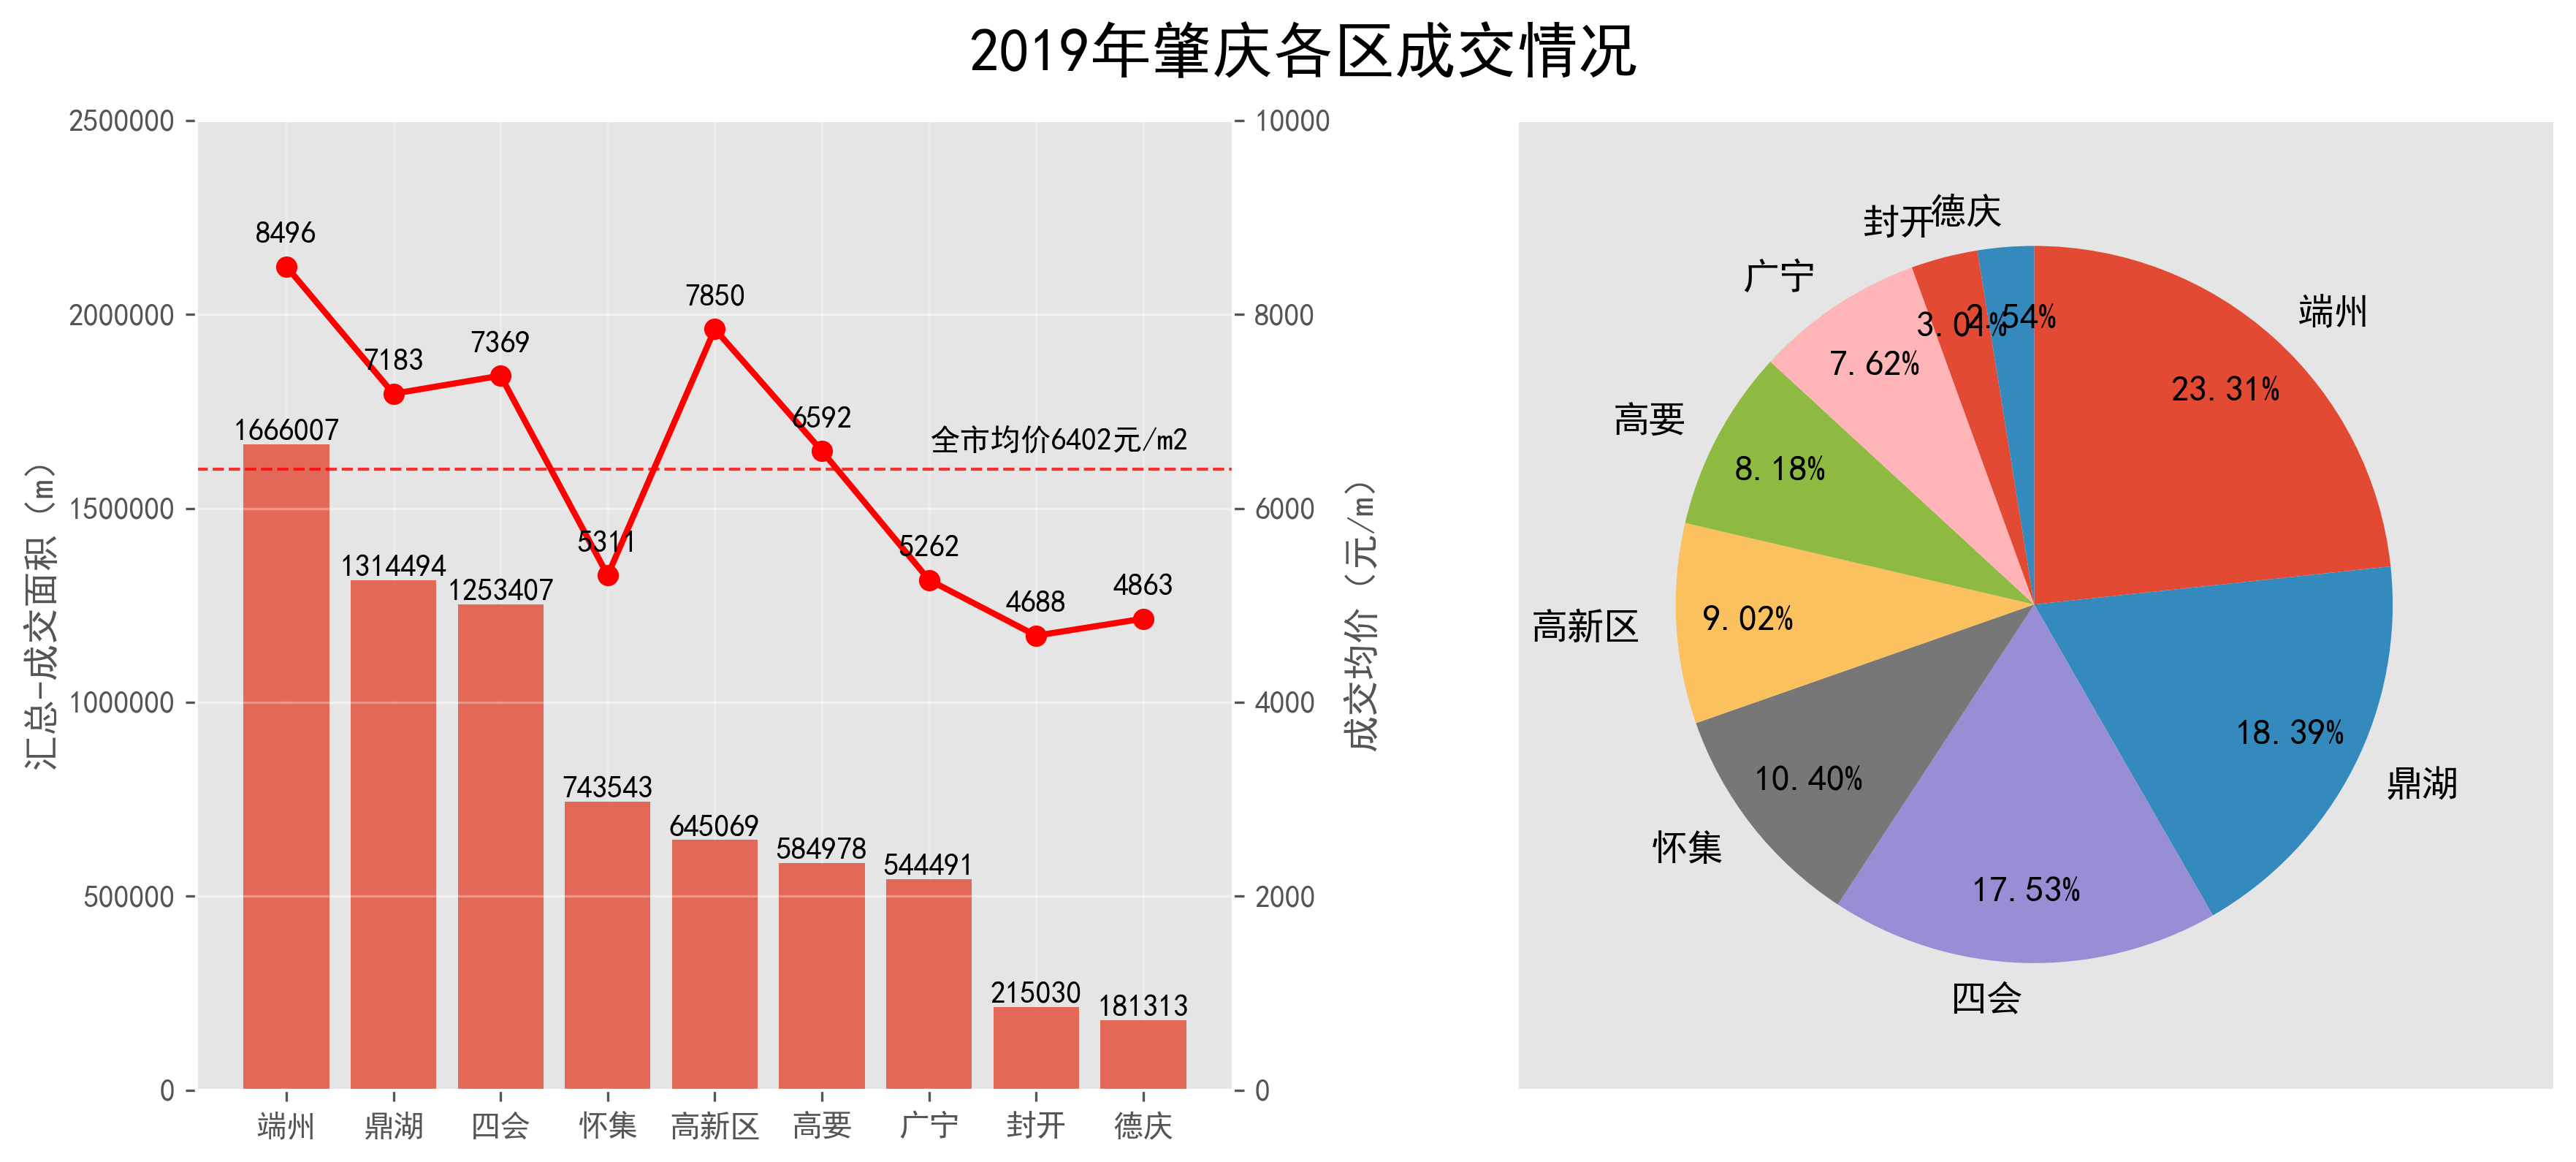

In [6]:
# 分区域成交结构图

def p4(df,type_,indicator_):
    # 肇庆分区域成交结构图
    # type_=住宅/办公楼/商业营业用房/其他/汇总
    # indicator_=成交套数（套）/成交面积（m）/成交总额（元）
    
    data_indicator = f4(df,type_,indicator_)
    data_price = f4(df,type_,'成交均价（元/m）')
    data = pd.merge(data_indicator,data_price,left_index = True,right_index=True)
    #data.rename(columns ={'成交总额（元）':'成交总额（亿元）'},inplace = True)
    x = data.index
    y1 = data[indicator_]
    y2 = data['成交均价（元/m）']
    
    df_some = pd.DataFrame({'step':[10000,1000000,100],'unit':['套','m2','亿元']},
                           index = ['成交套数（套）','成交面积（m）','成交总额（元）'])
    # 构建一个基本元素的集合，方便因应不同参数提取对应数据
    step = df_some.loc[indicator_]['step']   # 计算坐标极值的辅助参数
    unit = df_some.loc[indicator_]['unit']
    #print(step,type(step))
    
    price_max = y2.max()   # 获取均价最大值
    y2_max = get_scale(price_max,1000,2)   # 设置均价坐标最大值(设置为2000的倍数)
    y2_major_locator = MultipleLocator(2000)   # 设置次坐标(均价)刻度间隔
    t = y2_max/2000   # 次坐标刻度间隔数，方便后面设置主坐标时与次坐标间隔数统一
    
    indicator_max = y1.max()
    y1_max = 1.1*get_scale(indicator_max,step,1)
    y1_max = get_scale(y1_max,step,0.5)
    y1_max = math.floor(y1_max/t)*t
    # y1_max为主主坐标最大值
    y1_major_locator = MultipleLocator(y1_max/t)   # 主坐标刻度间隔，与次坐标一致
    
    fig,axes = plt.subplots(1,2,figsize = (12,5),dpi = 300)
    plt.suptitle('2019年肇庆各区成交情况',fontsize = 20,y = 1.05)
    fig.subplots_adjust(wspace = 1,hspace = 0,)   # 设置子图间上下间距
    
    ax = axes[0]
    ax.bar(x,y1,alpha = 0.8)
    ax.set_ylabel(type_ + '-' + indicator_)
    ax.yaxis.set_major_locator(y1_major_locator)
    plt.sca(ax)
    plt.ylim(0,y1_max)
    plt.grid(alpha = 0.3)
    #plt.axhline(y1.mean(),ls = '--',lw = 1,alpha = 0.8)   # 平均成交量线
    #plt.text(6,y1.mean() + step/20,'整体平均线%.0f' % y1.mean() + unit)   # 均值标示
    for a,b in zip(x,y1):
        plt.text(a,b+1,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 10)
    
    ax1 = ax.twinx()
    ax1.plot(x,y2,
            marker = 'o',
            color = 'r',
            ls = '-',
            lw = 2
             )
    
    ax1.set_ylabel('成交均价（元/m）')
    ax1.yaxis.set_major_locator(y2_major_locator)
    for a,b in zip(x,y2):
        plt.text(a,b+200,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 10)
    plt.sca(ax1)
    plt.axhline(y2.mean(),ls = '--',lw = 1,color = 'r',alpha = 0.8)   # 整体均价线
    plt.text(6,y2.mean() + 200,'全市均价%.0f元/m2'% y2.mean(),fontsize = 10)
    plt.ylim(0,y2_max)
    plt.grid(alpha = 0.3)
    
    ax2 = axes[1]
    ax2.pie(y1,   # 饼图
        labels = data.index,   # 显示标签
        labeldistance = 1.1,   # 标签与圆心的距离，默认为1.1
        autopct='%2.2f%%',   # 显示百分比
        pctdistance=0.8,   # 百分比与圆心距离，默认为0.6
        counterclock = False,   # True为逆时针呈现，False为顺时针呈现
        startangle=90,   #   设置起始角度
        textprops={'fontsize':12,'color':'k'},   # 设置字体大小
        frame = True,   # 显示图边框
            )
    plt.sca(ax2)
    plt.axis('equal')
    #plt.legend(loc='center right',   # 图例显示位置
               #fontsize = 12,   # 图例字体大小
               #frameon=False,   # 图例边框
               #edgecolor='blue',   # 图例边框颜色
               #facecolor='blue',   # 图例背景颜色,若无边框,参数无效
                #)
    plt.xticks(())   # 不显示X轴刻度值
    plt.yticks(())   # 不显示Y轴刻度值
    plt.tight_layout()   # 调节图像边界
    
    print(round(price_max),round(indicator_max),'\n',data)

# type_=住宅/办公楼/商业营业用房/其他/汇总
# indicator_=成交套数（套）/成交面积（m）/成交总额（元）
p4(df0,'汇总','成交面积（m）')

7782 1569


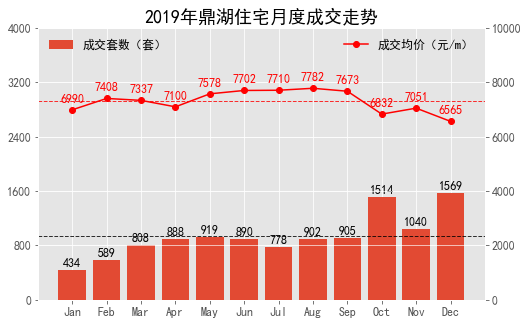

In [7]:
# 制定区成交量+均价组合图

def p1_single(df,region_,type_,indicator_):
    # 按区域及业态绘制组合图
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # type_ = 住宅/办公楼/商业营业用房/其他/汇总
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    
    price = f4(df,type_,'成交均价（元/m）')   # 各区全年均价
    price_mean = price.loc[region_].values   # 提取对应区均价
    
    data = f1(df,region_,type_,indicator_)
    x = list(data)
    y1 = data.loc[indicator_]
    y2 = data.loc['成交均价（元/m）']
    
    price_max = y2.max()
    volume_max = y1.max()
    some = {'step':[1000,100000,100],'unit':['套','m2','亿元']}
    df_some = pd.DataFrame(some,index = ['成交套数（套）','成交面积（m）','成交总额（元）'])
    step = df_some.loc[indicator_]['step']   # 计算坐标极值的辅助参数
    unit = df_some.loc[indicator_]['unit']   # 提取统计指标所用的单位
    
    y2_major_locator = MultipleLocator(2000)
    y2_max = get_scale(price_max,1000,2) + 2000
    t = y2_max/2000
    # 设置次坐标(均价)刻度为每2000一格
    
    y1_max = 1.5*get_scale(volume_max,step,1)
    y1_max = get_scale(y1_max,step,1)
    y1_max = math.floor(y1_max/t)*t
    y1_major_locator = MultipleLocator(y1_max/t)
    # 设置主坐标刻度
    
    fig,ax = plt.subplots(figsize = (8,5))
    ax.bar(x,y1,
           label = indicator_,
          )
    ax.legend(loc = 2,fontsize = 12,frameon=False,)
    ax.yaxis.set_major_locator(y1_major_locator)
    plt.sca(ax)
    plt.ylim(0,y1_max)
    plt.xticks(size = 12)   # 设置X轴坐标字体
    plt.yticks(size = 12)   # 设置Y轴坐标字体
    for a,b in zip(x,y1):
        plt.text(a,b + step/50,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 12,c = 'k')
    plt.axhline(y1.mean(),ls = '--',lw = 1,alpha = 0.8,c = 'k')   # 平均成交量线
    #plt.text(-0.5,y1_max/2 - step/20,'月平均成交%.0f' % y1.mean() + unit + ',',fontsize = 12,c = 'k')   # 均值标示
    #plt.text(-0.5,y1_max/2 - 5*step/20,'全年总成交%.0f' % y1.sum() + unit,fontsize = 12,c = 'k')   # 均值标示
    
    ax2 = plt.twinx()
    ax2.plot(x,y2,
             label = '成交均价（元/m）',
             marker = 'o',
             color = 'r',
             ls = '-'
            )
    ax2.legend(loc = 1,fontsize = 12,frameon=False,)
    ax2.yaxis.set_major_locator(y2_major_locator)
    plt.sca(ax2)
    plt.ylim(0,y2_max)
    plt.yticks(size = 12)   # 设置Y轴坐标字体
    plt.title('2019年' + region_ + type_ + '月度成交走势',fontsize = 18)
    plt.grid(alpha=0.8)   # 显示网格
    for a,b in zip(x,y2):
        plt.text(a,b+200,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 12,color = 'r')
    plt.axhline(y2.mean(),ls = '--',lw = 1,alpha = 0.8,c = 'r')   # 整体均价线
    #plt.text(-0.5,y2_max/2 + 400,'全年均价%.0f元/m2' % price_mean,fontsize = 12,c = 'r')   # 均值标示
    
    print(round(price_max),round(volume_max))

# region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
# type_ = 住宅/办公楼/商业营业用房/其他/汇总
# indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
p1_single(df0,'鼎湖','住宅','成交套数（套）')

187828 9091


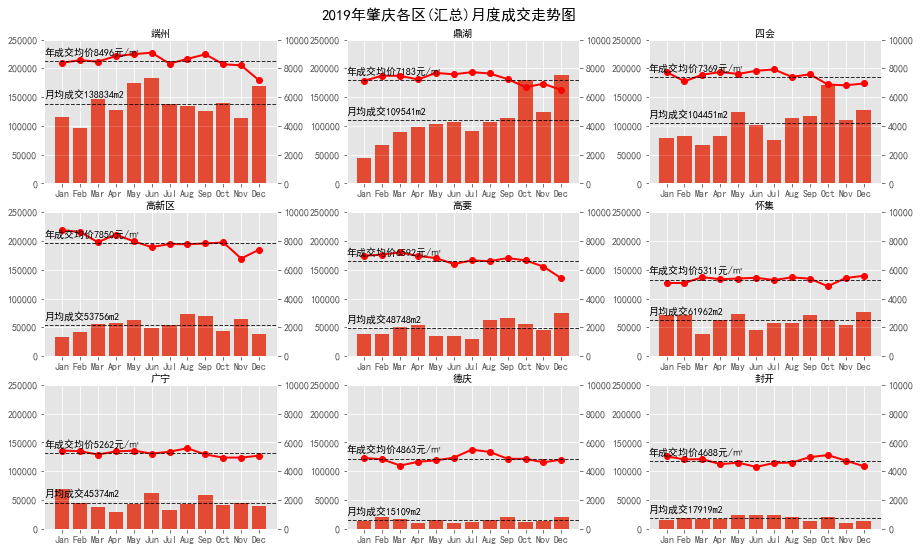

In [8]:
# 分区成交量+均价组合矩阵图

def p1_group(df,type_,indicator_):
    # 绘制组业态+均价组合图
    # type_ = 住宅/商业营业用房/其他/汇总(办公楼因有部分区域全年0成交，此函数会报错)
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    
    volume_ = f2(df,type_,indicator_)
    volume_.drop('肇庆',axis = 0,inplace = True)
    volume_max = volume_.max().max()
    # 获取主坐标最大值参考值
    
    price_ = f2(df,type_,'成交均价（元/m）')
    price_.drop('肇庆',axis = 0,inplace = True)
    price_max = price_.max().max()
    # 获取次坐标最大值(均价)参考值
    
    some = {'step':[1000,100000,100],'unit':['套','m2','亿元']}
    df_some = pd.DataFrame(some,index = ['成交套数（套）','成交面积（m）','成交总额（元）'])
    step = df_some.loc[indicator_]['step']   # 计算坐标极值的辅助参数
    unit = df_some.loc[indicator_]['unit']   # 提取统计指标所用的单位
    # 构建一个基本元素的集合，方便因应不同参数提取对应数据
    
    y2_max = get_scale(price_max,1000,2)   # 设置次坐标(均价)最大值(设置为2000的倍数)
    y2_major_locator = MultipleLocator(2000)   # 设置次坐标(均价)刻度间隔
    t = y2_max/2000   # 次坐标刻度间隔数，方便后面设置主坐标时与次坐标间隔数统一
    
    y1_max = 1.2*get_scale(volume_max,step,1)
    y1_max = get_scale(y1_max,step,0.5)
    y1_max = math.floor(y1_max/t)*t
    y1_major_locator = MultipleLocator(y1_max/t)
    # 主坐标刻度值与次坐标一致
    
    region_s = ['端州', '鼎湖', '四会', '高新区', '高要', '怀集', '广宁', '德庆', '封开']
    price = f4(df,type_,'成交均价（元/m）')   # 各区全年均价
    
    fig,axes = plt.subplots(3,3,sharex = False,sharey = False,figsize = (15,9))
    plt.suptitle('2019年肇庆各区' + "(" + type_ + ")" + '月度成交走势图',fontsize = 15,c = 'k',y = 0.93)
    fig.subplots_adjust(
                        wspace = 0.3,   # 设置子图间左右间距
                        #hspace = 0,   # 设置子图间上下间距
                        )
    
    for i in range(len(region_s)):
        data = f1(df,region_s[i],type_,indicator_)
        x = list(data)
        y1 = data.loc[indicator_]
        y2 = data.loc['成交均价（元/m）']
        price_mean = price.loc[region_s[i]].values   # 提取对应区均价
        
        price_interval = (round(data.loc['成交均价（元/m）'].min()),round(data.loc['成交均价（元/m）'].max()))   # 提各区取区间价
        
        ax = axes[math.floor(i/3),(i%3)]
        ax.bar(x,y1,
               label = indicator_,
                  )
        ax.set_title(region_s[i],fontsize = 10,c = 'k',y = 0.98)
        ax.yaxis.set_major_locator(y1_major_locator)
        #ax.set_ylabel(type_ + indicator_)
        #ax.legend(loc = 2,fontsize = 8)
        plt.sca(ax)
        plt.ylim(0,y1_max)
        #for a,b in zip(x,y1):
        #   plt.text(a,b+1,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 8)
        plt.axhline(y1.mean(),ls = '--',lw = 1,color = 'k',alpha = 0.8)   # 月均成交量线
        plt.text(-1,y1.mean() + step/10,'月均成交%.0f' % y1.mean() + unit,c = 'k')
        #plt.text(3.1,y1.mean() + step/10,',全年总成交%.0f' % y1.sum() + unit,c = 'k')
        
        ax2 = ax.twinx()
        ax2.plot(x,y2,
                 label = '成交均价（元/m）',
                 marker = 'o',
                 color = 'r',
                 ls = '-',
                 linewidth = '2',
                )
        #ax2.legend(loc = 1,fontsize = 8)
        ax2.yaxis.set_major_locator(y2_major_locator)
        plt.sca(ax2)
        plt.ylim(0,y2_max)
        plt.grid(alpha=0.2)   # 显示网格
        #for a,b in zip(x,y2):
        #    plt.text(a,b+1,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 8,color = 'r')
        plt.axhline(price_mean,ls = '--',lw = 1,color = 'k',alpha = 0.8)   # 年成交均价线
        plt.text(-1,price_mean + 400,'年成交均价%.0f元/㎡' % price_mean,c = 'k')
        #plt.text(4.3,price_mean + 400, price_interval,c = 'k')
        
    print(round(volume_max),round(price_max))

# type_ = 住宅/办公楼/商业营业用房/其他/汇总
# indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
p1_group(df0,'汇总','成交面积（m）')

6058392 10560
12000000.0 12000


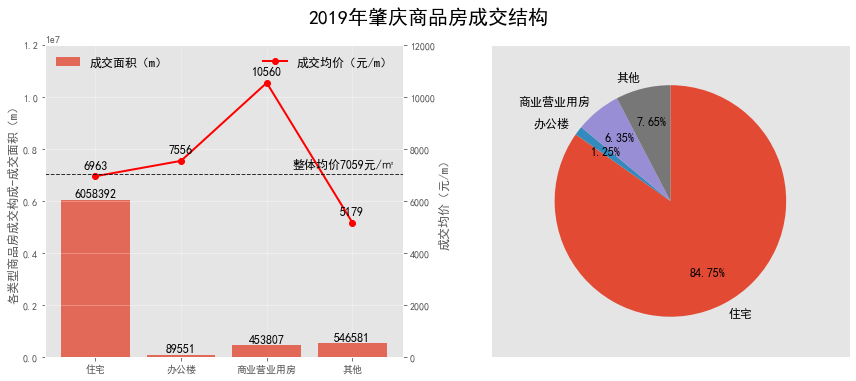

In [47]:
# 分类型成交结构矩阵图

def p5_region(df,indicator_,region_):
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    
    data = f5_region(df,indicator_,region_)
    price = round(data.loc['汇总','price'])   # 提取整体均价
    data.drop(['汇总'],axis = 0,inplace = True)
    indicator_max = round(data[region_].max())
    price_max = round(data['price'].max())
    
    some = {'step':[10000,1000000,100],'unit':['套','m2','亿元']}
    df_some = pd.DataFrame(some,index = ['成交套数（套）','成交面积（m）','成交总额（元）'])
    step = df_some.loc[indicator_,'step']   # 计算坐标极值的辅助参数
    unit = df_some.loc[indicator_,'unit']   # 提取统计指标所用的单位
    # 构建一个基本元素的集合，方便因应不同参数提取对应数据
    
    y2_max = get_scale(price_max,1000,2)  # 设置次坐标(均价)最大值(设置为2000的倍数)
    y2_major_locator = MultipleLocator(2000)   # 设置次坐标(均价)刻度间隔
    t = y2_max/2000   # 次坐标刻度间隔数，方便后面设置主坐标时与次坐标间隔数统一
    
    y1_max = get_scale(indicator_max,step)
    m = y1_max/step
    if m < t:
        m = t
    else:
        m = 2*t
    y1_max = m*step
    y1_major_locator = MultipleLocator(y1_max/t)
    # 主坐标刻度值与次坐标一致
    
    x = data.index
    y1 = data.loc[:,region_]
    y2 = data.loc[:,'price']
    
    fig,axes = plt.subplots(1,2,figsize = (12,5))
    plt.suptitle('2019年' + region_ + '商品房成交结构',fontsize = 20,c = 'k',y = 1.05)
    fig.subplots_adjust(wspace = 1,hspace = 0)
    
    ax = axes[0]
    ax.bar(x,y1,alpha = 0.8,label = indicator_)
    ax.set_ylabel('各类型商品房成交构成' + '-' + indicator_)
    ax.yaxis.set_major_locator(y1_major_locator)
    ax.legend(loc = 2,fontsize = 12,frameon=False,)
    plt.sca(ax)
    plt.ylim(0,y1_max)
    plt.grid(alpha = 0.3)
    for a,b in zip(x,y1):
        plt.text(a,b+5,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 12,c = 'k')
    
    ax1 = ax.twinx()
    ax1.plot(x,y2,marker = 'o',color = 'r',ls = '-',lw = 2,label = '成交均价（元/m）')
    ax1.set_ylabel('成交均价（元/m）')
    ax1.yaxis.set_major_locator(y2_major_locator)
    ax1.legend(loc = 1,fontsize = 12,frameon=False,)
    for a,b in zip(x,y2):
        plt.text(a,b+200,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 12,c = 'k')
    plt.sca(ax1)
    plt.axhline(price,ls = '--',lw = 1,color = 'k',alpha = 0.8)   # 年成交均价线
    plt.text(2.3,price + 200,'整体均价%.0f元/㎡' % price,c = 'k',fontsize = 12)
    plt.ylim(0,y2_max)
    plt.grid(alpha = 0.3)
    
    ax2 = axes[1]
    ax2.pie(y1,
            labels = data.index,   # 显示标签
            labeldistance = 1.1,   # 标签与圆心的距离，默认是1.1
            autopct = '%2.2f%%',   # 显示百分比
            pctdistance = 0.7,   # 百分比与圆心的距离，默认是0.6
            counterclock = False,   # True是逆时针呈现，False是顺时针呈现
            startangle = 90,   # 起始角度
            textprops = {'fontsize':12,'color':'k'},   # 字体设置
            frame = True,   # 是否显示图边框 
            )
    plt.sca(ax2)
    plt.axis('equal')
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout()
    
    print(indicator_max,price_max)
    print(y1_max,y2_max)
    #return data

p5_region(df0,'成交面积（m）','肇庆')

1666007 14263


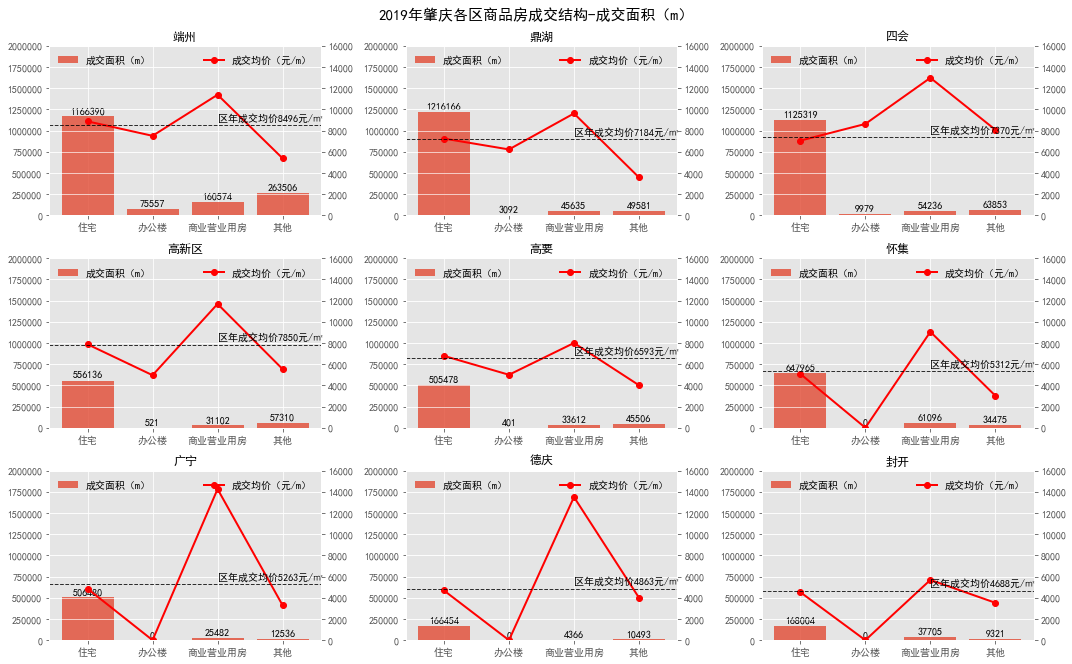

In [7]:
def p5_group(df,indicator_):
    # 各区商品房成交结构九宫格组图
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    
    some = {'step':[10000,1000000,100],'unit':['套','m2','亿元']}
    df_some = pd.DataFrame(some,index = ['成交套数（套）','成交面积（m）','成交总额（元）'])
    step = df_some.loc[indicator_,'step']   # 计算坐标极值的辅助参数
    unit = df_some.loc[indicator_,'unit']   # 提取统计指标所用的单位
    # 构建一个基本元素的集合，方便因应不同参数提取对应数据
    
    d1 = f4(df,'汇总',indicator_)
    indicator_max = d1[indicator_].max()   # 成交指标最大值
    p1 = f4(df,'商业营业用房','成交均价（元/m）')
    price_max = p1['成交均价（元/m）'].max()   # 均价最大值
    
    y2_max = get_scale(price_max,10000,0.5)  # 设置次坐标(均价)最大值(设置为2000的倍数)
    y2_max = get_scale(y2_max,1000)
    y2_major_locator = MultipleLocator(2000)   # 设置次坐标(均价)刻度间隔
    t = y2_max/2000   # 次坐标刻度间隔数，方便后面设置主坐标时与次坐标间隔数统一
    
    y1_max = get_scale(indicator_max,step)
    y1_max = t*step/4
    y1_major_locator = MultipleLocator(y1_max/t)
    # 主坐标刻度值与次坐标一致
    region_s = ['端州', '鼎湖', '四会', '高新区', '高要', '怀集', '广宁', '德庆', '封开']
    
    fig,axes = plt.subplots(3,3,sharex = False,sharey = False,figsize = (15,9))
    plt.suptitle('2019年肇庆各区商品房成交结构' + '-' + indicator_,fontsize = 15,c = 'k',y = 1.02)
    fig.subplots_adjust(wspace = 0.1,hspace = 0.3,)
    
    for i in range(len(region_s)):
        data = f5_region(df,indicator_,region_s[i])
        price_region = data.loc['汇总','price']
        data.drop(['汇总'],axis = 0,inplace = True)
        x = data.index
        y1 = data.loc[:,region_s[i]]
        y2 = data.loc[:,'price']
        
        ax = axes[math.floor(i/3),(i%3)]
        ax.bar(x,y1,alpha = 0.8,label = indicator_)
        ax.set_title(region_s[i],fontsize = 12,c = 'k',y = 1)
        ax.yaxis.set_major_locator(y1_major_locator)
        ax.legend(loc = 2,fontsize = 10,frameon = False,)
        plt.sca(ax)
        plt.ylim(0,y1_max)
        for a,b in zip(x,y1):
            plt.text(a,b+y1_max/100,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 10)
        #plt.yticks(())   # 不显示Y轴刻度值
        
        ax2 = ax.twinx()
        ax2.plot(x,y2,
                 label = '成交均价（元/m）',
                 marker = 'o',
                 color = 'r',
                 ls = '-',
                 linewidth = '2',
                )
        ax2.yaxis.set_major_locator(y2_major_locator)
        ax2.legend(loc = 1,fontsize = 10,frameon = False)
        plt.sca(ax2)
        plt.ylim(0,y2_max)
        plt.grid(alpha=0.8)   # 显示网格
        #for a,b in zip(x,y2):
            #plt.text(a,b+400,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 10)
        #plt.yticks(())   # 不显示Y轴刻度值
        plt.axhline(price_region,ls = '--',lw = 1,color = 'k',alpha = 0.8)   # 区整体均价线
        plt.text(2,price_region + 400,'区年成交均价%.0f元/㎡' % price_region,c = 'k')
        
    plt.tight_layout()
    print(round(indicator_max),round(price_max))

# indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
p5_group(df0,'成交面积（m）')

1666007 14263


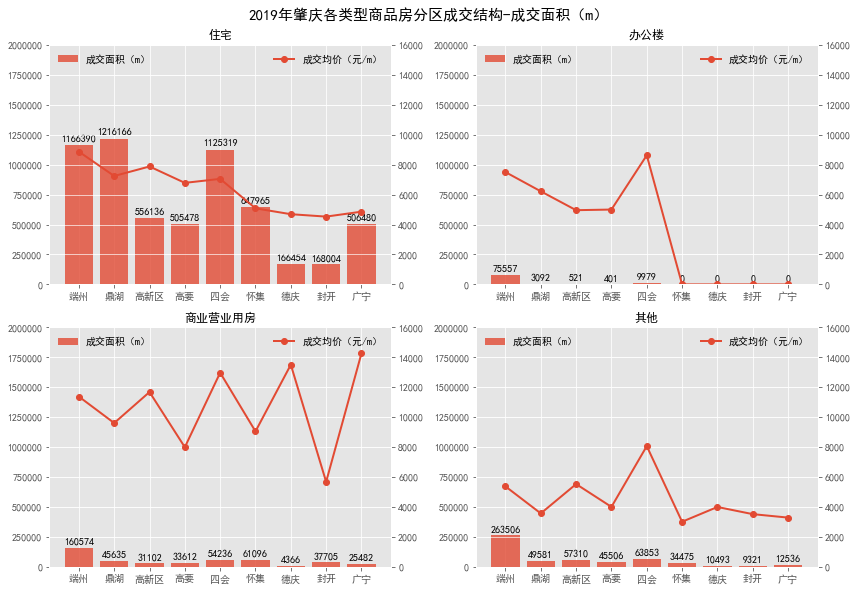

In [10]:
def p5_type(df,indicator_):
    # 四种物业形式各区成交构成四格组图
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    
    some = {'step':[10000,1000000,100],'unit':['套','m2','亿元']}
    df_some = pd.DataFrame(some,index = ['成交套数（套）','成交面积（m）','成交总额（元）'])
    step = df_some.loc[indicator_,'step']   # 计算坐标极值的辅助参数
    unit = df_some.loc[indicator_,'unit']   # 提取统计指标所用的单位
    # 构建一个基本元素的集合，方便因应不同参数提取对应数据
    
    d1 = f4(df,'汇总',indicator_)
    indicator_max = d1[indicator_].max()   # 成交指标最大值
    p1 = f4(df,'商业营业用房','成交均价（元/m）')
    price_max = p1['成交均价（元/m）'].max()   # 均价最大值
    
    y2_max = get_scale(price_max,10000,0.5)  # 设置次坐标(均价)最大值(设置为2000的倍数)
    y2_max = get_scale(y2_max,1000)
    y2_major_locator = MultipleLocator(2000)   # 设置次坐标(均价)刻度间隔
    t = y2_max/2000   # 次坐标刻度间隔数，方便后面设置主坐标时与次坐标间隔数统一
    
    y1_max = get_scale(indicator_max,step)
    y1_max = t*step/4
    y1_major_locator = MultipleLocator(y1_max/t)
    # 主坐标刻度值与次坐标一致
    
    type_s = ['住宅', '办公楼', '商业营业用房', '其他']
    
    fig,axes = plt.subplots(2,2,sharex = False,sharey = False,figsize = (12,8))
    plt.suptitle('2019年肇庆各类型商品房分区成交结构' + '-' + indicator_,fontsize = 15,c = 'k',y = 1.02)
    fig.subplots_adjust(wspace = 0.1,hspace = 0.3,)
    
    for i in range(len(type_s)):
        data = f5_type(df0,indicator_,type_s[i])
        data.drop('肇庆',axis = 0,inplace = True)
        x = data.index
        y1 = data.loc[:,indicator_]
        y2 = data.loc[:,'成交均价（元/m）']
        #y3 = data.loc[:,'percentage']
        
        ax = axes[math.floor(i/2),(i%2)]
        ax.bar(x,y1,alpha = 0.8,label = indicator_)
        ax.set_title(type_s[i],fontsize = 12,c = 'k',y = 1)
        ax.legend(loc = 2,fontsize = 10,frameon = False,)
        ax.yaxis.set_major_locator(y1_major_locator)
        plt.sca(ax)
        plt.ylim(0,y1_max)
        for a,b in zip(x,y1):
            plt.text(a,b+y1_max/100,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 10)
        
        ax2 = ax.twinx()
        ax2.plot(x,y2,
                 label = '成交均价（元/m）',
                 marker = 'o',
                 ls = '-',
                 lw = '2',
                )
        ax2.legend(loc = 1,fontsize = 10,frameon = False)
        ax2.yaxis.set_major_locator(y2_major_locator)
        plt.sca(ax2)
        plt.ylim(0,y2_max)
        plt.grid(alpha = 0.8)
        #for a,b in zip(x,y2):
            #plt.text(a,b+400,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 10)
        
    plt.tight_layout()
    print(round(indicator_max),round(price_max))

# indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
p5_type(df0,'成交面积（m）')

11236


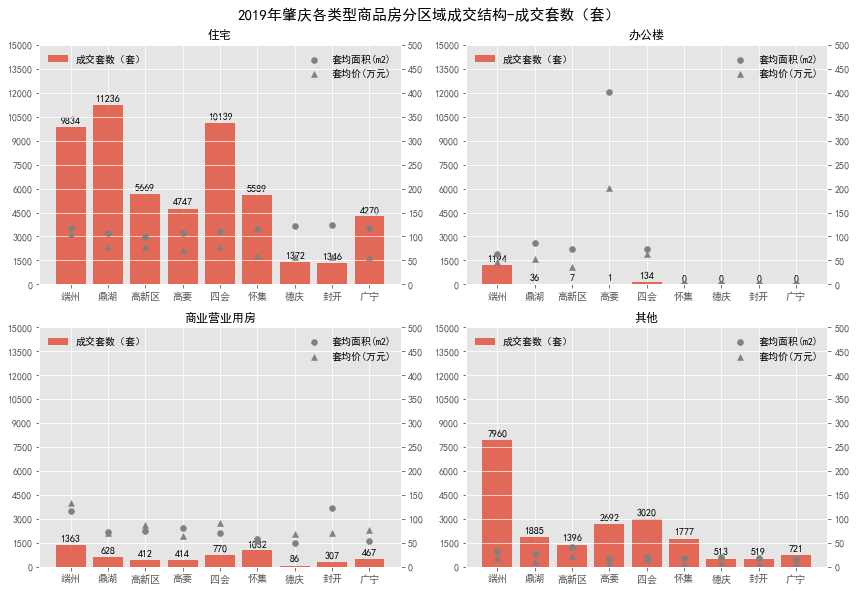

In [9]:
def p5_type2(df,indicator_):
    # 四种物业形式各区成交构成四格组图
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    
    some = {'step':[10000,100,100],'unit':['套','m2','万元']}
    df_some = pd.DataFrame(some,index = ['成交套数（套）','套均面积(m2)','套均价(万元)'])
    step = df_some.loc[indicator_,'step']   # 计算坐标极值的辅助参数
    unit = df_some.loc[indicator_,'unit']   # 提取统计指标所用的单位
    # 构建一个基本元素的集合，方便因应不同参数提取对应数据
    
    d1 = f4(df,'住宅',indicator_)
    indicator_max = d1[indicator_].max()   # 成交指标最大值
    #p1 = f4(df,'商业营业用房','成交均价（元/m）')
    #price_max = p1['成交均价（元/m）'].max()   # 均价最大值
    
    y2_max = 500
    #y2_max = get_scale(price_max,10000,0.5)  # 设置次坐标(均价)最大值(设置为2000的倍数)
    #y2_max = get_scale(y2_max,1000)
    y2_major_locator = MultipleLocator(50)   # 设置次坐标(均价)刻度间隔
    t = 10   # 次坐标刻度间隔数，方便后面设置主坐标时与次坐标间隔数统一
    
    y1_max = get_scale(indicator_max,step,0.5)
    #y1_max = t*step/2
    y1_major_locator = MultipleLocator(y1_max/t)
    # 主坐标刻度值与次坐标一致
    
    type_s = ['住宅', '办公楼', '商业营业用房', '其他']
    
    fig,axes = plt.subplots(2,2,sharex = False,sharey = False,figsize = (12,8))
    plt.suptitle('2019年肇庆各类型商品房分区域成交结构' + '-' + indicator_,fontsize = 15,c = 'k',y = 1.02)
    fig.subplots_adjust(wspace = 0.1,hspace = 0.3,)
    
    for i in range(len(type_s)):
        data = f5_type(df0,indicator_,type_s[i])
        y2_ave = data.loc['肇庆','套均面积(m2)']
        y3_ave = data.loc['肇庆','套均价(万元)']
        data.drop('肇庆',axis = 0,inplace = True)
        x = data.index
        y1 = data.loc[:,indicator_]
        y2 = data.loc[:,'套均面积(m2)']
        y3 = data.loc[:,'套均价(万元)']
        
        ax = axes[math.floor(i/2),(i%2)]
        ax.bar(x,y1,alpha = 0.8,label = indicator_)
        ax.set_title(type_s[i],fontsize = 12,c = 'k',y = 1)
        ax.legend(loc = 2,fontsize = 10,frameon = False,)
        ax.yaxis.set_major_locator(y1_major_locator)
        plt.sca(ax)
        plt.ylim(0,y1_max)
        for a,b in zip(x,y1):
            plt.text(a,b+y1_max/100,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 10)
        
        ax2 = ax.twinx()
        ax2.scatter(x,y2,
                 label = '套均面积(m2)',
                 marker = 'o',
                 #ls = '-',
                 #lw = '1',
                 c = 'gray'
                )
        ax2.scatter(x,y3,
                 label = '套均价(万元)',
                 marker = '^',
                 #ls = '-',
                 #lw = '1',
                 c = 'gray'
                )
        ax2.legend(loc = 1,fontsize = 10,frameon = False)
        ax2.yaxis.set_major_locator(y2_major_locator)
        plt.sca(ax2)
        plt.ylim(0,y2_max)
        plt.grid(alpha = 0.8)
        #for a,b in zip(x,y2):
            #plt.text(a,b+10,'%.0f' % b,ha = 'center',va = 'bottom',fontsize = 10)
        #plt.axhline(y2_ave,ls = '--',lw = 1,color = 'b',alpha = 0.8)   # 区整体平均线
        #plt.text(6.3,400,'全市套均面积%.0f㎡' % y2_ave,c = 'b')
        #plt.axhline(y3_ave,ls = '--',lw = 1,color = 'g',alpha = 0.8)   # 区整体平均线
        #plt.text(6.3,370,'全市套均价%.0f万元' % y3_ave,c = 'g')
        
    plt.tight_layout()
    print(round(indicator_max))

# indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
p5_type2(df0,'成交套数（套）')

In [32]:
# 筛选出每种类型的分区构成数据合并计算百分比——函数f5_type(df,indicator_,type_)
    # df = 原始数据集
    # indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
    # type_ = 住宅/办公楼/商业营业用房/其他
    
sn1 = f5_type(df0,'成交套数（套）','住宅')
#sn1 = sn1.apply(pd.to_numeric,errors = 'ignore')
#print(sn1.info())
print(sn1)
w = sn1.loc['肇庆','套均面积(m2)']
w

住宅      成交套数（套）  套均面积(m2)  套均价(万元)  成交均价（元/m）       占比
region                                                
端州         9834       119      105       8867   18.14%
鼎湖        11236       108       78       7242   20.73%
高新区        5669        98       77       7877   10.46%
高要         4747       106       72       6783    8.76%
四会        10139       111       78       7049   18.71%
怀集         5589       116       59       5081   10.31%
德庆         1372       121       57       4690    2.53%
封开         1346       125       57       4529    2.48%
广宁         4270       119       58       4858    7.88%
肇庆        54202       112       78       6963  100.00%


111.77432972953027

In [45]:
# f5_region(df,indicator_,region_)
# indicator_ = 成交套数（套）/成交面积（m）/成交总额（元）
# region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    
sn2 = f5_region(df0,'成交总额（元）','肇庆')
sn2

,肇庆,percentage,price
成交总额（元）,,,
住宅,422,83.60%,6963
办公楼,7,1.34%,7556
商业营业用房,48,9.50%,10560
其他,28,5.61%,5179
汇总,505,100.00%,7059


20610.0 31500.0


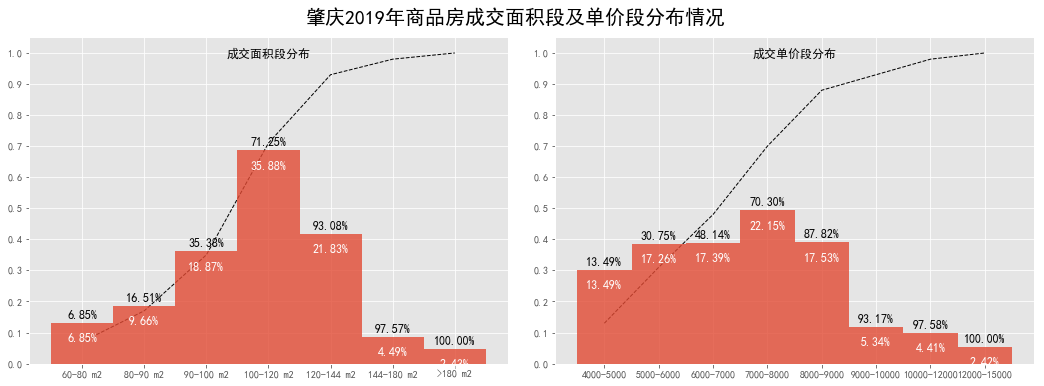

In [10]:
def p3_single(df,region_):
    # 按行政区筛选出面积段年度数据，并剔除60㎡以下数据
    # df = 原始数据集
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    
    
    # 导入面积段数据集
    data_area = f3_area(df,region_)
    a_z1 = data_area.loc[:,'占比']
    a_z2 = data_area.loc[:,'累计占比']
    a_x = data_area.index
    a_y1 = data_area.loc[:,'累计占比_value']
    a_y2 = data_area.loc[:,'套数']
    a_max = a_y2.max()
    # 数据变量用于第1个子图
    
    # 导入单价段数据集
    data_price = f3_price(df,region_)
    p_z1 = data_price.loc[:,'占比']
    p_z2 = data_price.loc[:,'累计占比']
    p_x = data_price.index
    p_y1 = data_price.loc[:,'累计占比_value']
    p_y2 = data_price.loc[:,'套数']
    p_max = p_y2.max()
    # 数据变量用于第2个子图
    
    m_max = np.array([a_max,p_max]).max()
    y_max = get_scale(m_max,10000)
    step = y_max/10
    y_max = y_max*1.05
    print(m_max,y_max)
    # 计算y轴坐标极值
    
    fig,axes = plt.subplots(1,2,figsize = (18,6))
    plt.suptitle(region_ + '2019年商品房成交面积段及单价段分布情况',fontsize = 20,y = 0.95)
    fig.subplots_adjust(wspace = 0.1,hspace = 0,)   # 设置子图间上下间距
    
    # 第1个子图——面积分布
    ax = axes[0]
    ax.plot(a_x,a_y1,ls = '--',lw = '1',color = 'k')
    ax.set_title('成交面积段分布',fontsize = 12,c = 'k',y = 0.92)
    a_y_major_locator = MultipleLocator(0.1)
    ax.yaxis.set_major_locator(a_y_major_locator)
    plt.sca(ax)
    plt.ylim(0,1.05)
    
    ax1 = ax.twinx()
    ax1.bar(a_x,a_y2,alpha = 0.8,width = 1,)
    a_y2_major_locator = MultipleLocator(step)
    ax1.yaxis.set_major_locator(a_y2_major_locator)
    plt.sca(ax1)
    plt.ylim(0,y_max)
    plt.yticks(())   # 不显示Y轴刻度值
    for a,b,c in zip(a_x,a_y2,a_z2):
        plt.text(a,b + 200,'%s' % c,ha = 'center',va = 'bottom',fontsize = 12,c = 'k')
    for a,b,c in zip(a_x,a_y2,a_z1):
        plt.text(a,b - round(m_max/10),'%s' % c,ha = 'center',va = 'bottom',fontsize = 12,c = 'w')
    
    
    # 第2个子图——单价分布
    ax2 = axes[1]
    ax2.plot(p_x,p_y1,ls = '--',lw = '1',color = 'k')
    ax2.set_title('成交单价段分布',fontsize = 12,c = 'k',y = 0.92)
    p_y_major_locator = MultipleLocator(0.1)
    ax2.yaxis.set_major_locator(p_y_major_locator)
    plt.sca(ax2)
    plt.ylim(0,1.05)
    #plt.yticks(())   # 不显示Y轴刻度值
    
    ax3 = ax2.twinx()
    ax3.bar(p_x,p_y2,alpha = 0.8,width = 1,)
    p_y2_major_locator = MultipleLocator(step)
    ax3.yaxis.set_major_locator(p_y2_major_locator)
    plt.sca(ax3)
    plt.ylim(0,y_max)
    plt.yticks(())   # 不显示Y轴刻度值
    for a,b,c in zip(p_x,p_y2,p_z2):
        plt.text(a,b + 200,'%s' % c,ha = 'center',va = 'bottom',fontsize = 12,c = 'k')
    for a,b,c in zip(p_x,p_y2,p_z1):
        plt.text(a,b - round(m_max/10),'%s' % c,ha = 'center',va = 'bottom',fontsize = 12,c = 'w')
    
p3s = p3_single(df0,'肇庆')

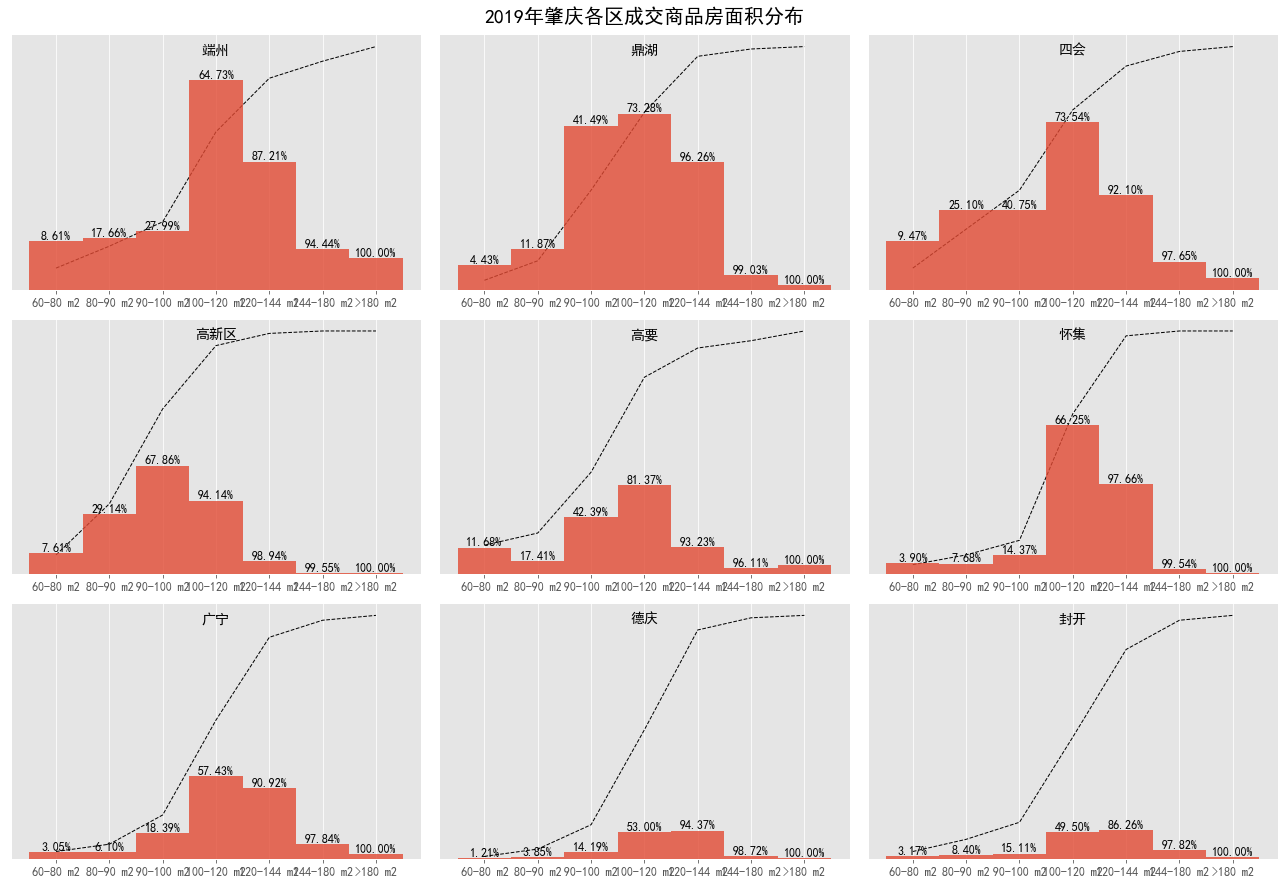

In [11]:
def p3_group_area():
    # 各区商铺住宅按面积成交结构九宫格图
    
    region_s = ['端州', '鼎湖', '四会', '高新区', '高要', '怀集', '广宁', '德庆', '封开']
    
    fig,axes = plt.subplots(3,3,sharex = False,sharey = False,figsize = (18,12))
    plt.suptitle('2019年肇庆各区成交商品房面积分布',fontsize = 20,c = 'k',y = 1.02)
    fig.subplots_adjust(wspace = 0.1,hspace = 0.3,)
    
    for i in range(len(region_s)):
        data = f3_area(df0,region_s[i])
        x = data.index
        y1 = data.loc[:,'累计占比_value']
        y2 = data.loc[:,'套数']
        z = data.loc[:,'累计占比']
        
        ax = axes[math.floor(i/3),(i%3)]
        ax.plot(x,y1,ls = '--',lw = '1',color = 'k')
        ax.set_title(region_s[i],fontsize = 14,c = 'k',y = 0.9)
        y1_major_locator = MultipleLocator(0.1)
        ax.yaxis.set_major_locator(y1_major_locator)
        plt.sca(ax)
        plt.ylim(0,1.05)
        plt.xticks(fontsize = 12)   # 设置X坐标轴标签字体大小
        plt.yticks(())   # 不显示Y轴刻度值
    
        ax1 = ax.twinx()
        ax1.bar(x,y2,alpha = 0.8,width = 1,)
        y2_major_locator = MultipleLocator(500)
        ax1.yaxis.set_major_locator(y2_major_locator)
        plt.sca(ax1)
        plt.ylim(0,5250)
        plt.yticks(())   # 不显示Y轴刻度值
        for a,b,c in zip(x,y2,z):
            plt.text(a,b + 1,'%s' % c,ha = 'center',va = 'bottom',fontsize = 12,c = 'k')
        
    plt.tight_layout()

pga = p3_group_area()

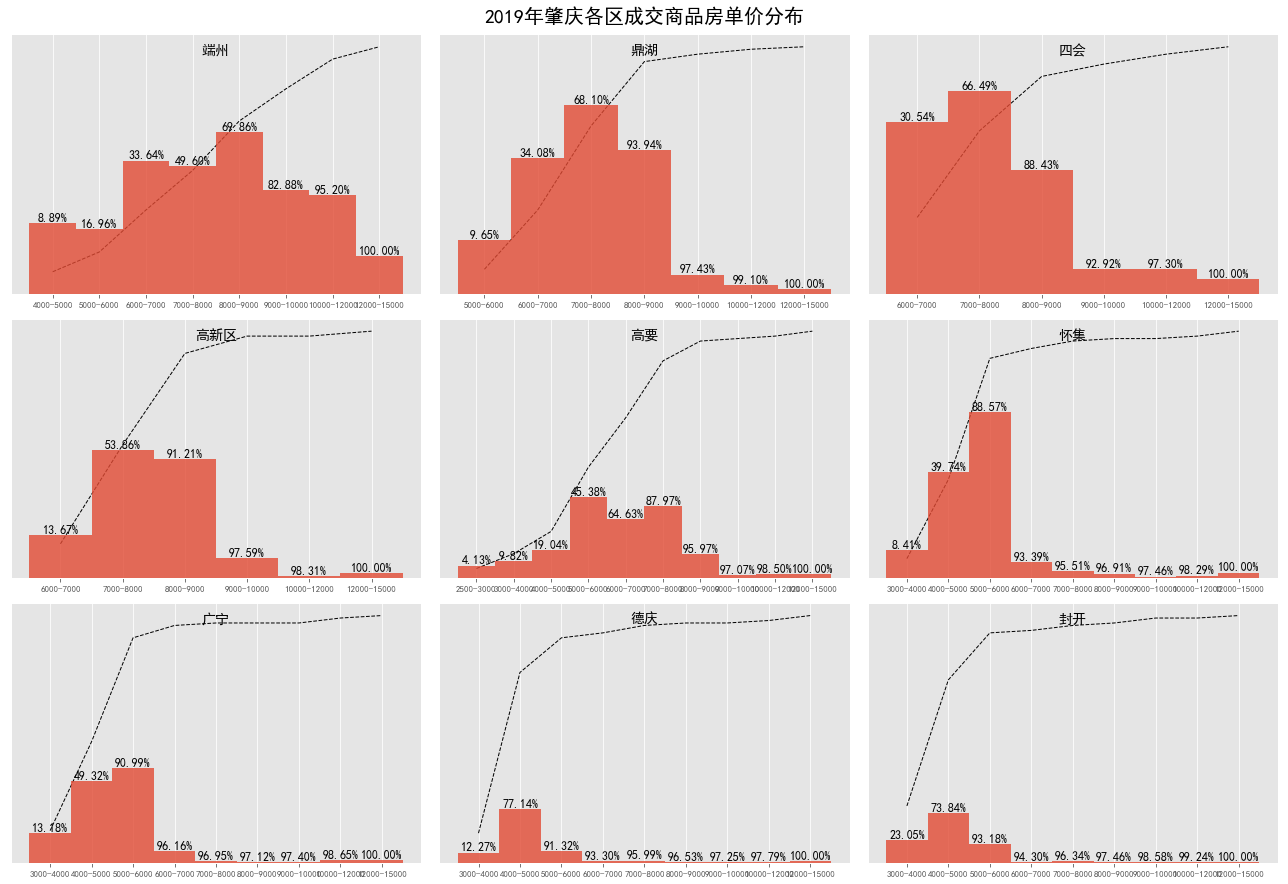

In [12]:
def p3_group_price():
    # 各区商铺住宅按面积成交结构九宫格图
    
    region_s = ['端州', '鼎湖', '四会', '高新区', '高要', '怀集', '广宁', '德庆', '封开']
    
    fig,axes = plt.subplots(3,3,sharex = False,sharey = False,figsize = (18,12))
    plt.suptitle('2019年肇庆各区成交商品房单价分布',fontsize = 20,c = 'k',y = 1.02)
    fig.subplots_adjust(wspace = 0.1,hspace = 0.3,)
    
    for i in range(len(region_s)):
        data = f3_price(df0,region_s[i])
        x = data.index
        y1 = data.loc[:,'累计占比_value']
        y2 = data.loc[:,'套数']
        z = data.loc[:,'累计占比']
        
        ax = axes[math.floor(i/3),(i%3)]
        ax.plot(x,y1,ls = '--',lw = '1',color = 'k')
        ax.set_title(region_s[i],fontsize = 14,c = 'k',y = 0.9)
        y1_major_locator = MultipleLocator(0.1)
        ax.yaxis.set_major_locator(y1_major_locator)
        plt.sca(ax)
        plt.ylim(0,1.05)
        plt.xticks(fontsize = 9)   # 设置X坐标轴标签字体大小
        plt.yticks(())   # 不显示Y轴刻度值
    
        ax1 = ax.twinx()
        ax1.bar(x,y2,alpha = 0.8,width = 1,)
        y2_major_locator = MultipleLocator(500)
        ax1.yaxis.set_major_locator(y2_major_locator)
        plt.sca(ax1)
        plt.ylim(0,5250)
        plt.yticks(())   # 不显示Y轴刻度值
        for a,b,c in zip(x,y2,z):
            plt.text(a,b + 1,'%s' % c,ha = 'center',va = 'bottom',fontsize = 12,c = 'k')
        
    plt.tight_layout()

pgp = p3_group_price()

In [39]:
pr = f3_price(df0,'端州')
pr

,套数,占比,累计占比,累计占比_value
端州-单价段,,,,
4000-5000,1438,8.89%,8.89%,0
5000-6000,1305,8.07%,16.96%,0
6000-7000,2699,16.68%,33.64%,0
7000-8000,2582,15.96%,49.60%,0
8000-9000,3278,20.26%,69.86%,1
9000-10000,2106,13.02%,82.88%,1
10000-12000,1993,12.32%,95.20%,1
12000-15000,776,4.80%,100.00%,1


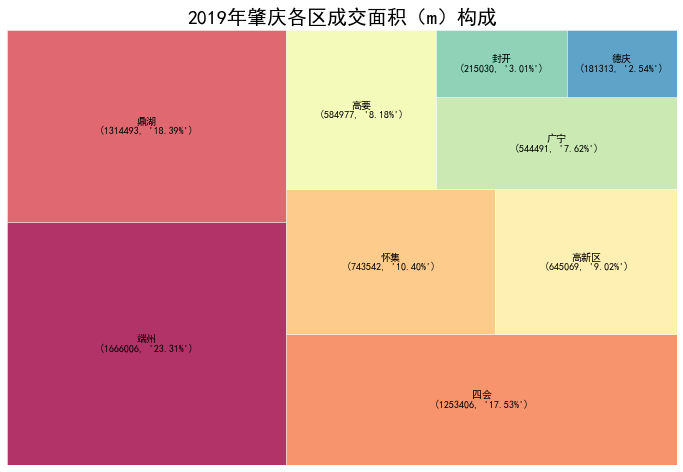

In [13]:
# 区域成交构成树地图
def p4_tree(df,type_,indicator_):
    # 肇庆分区域成交结构图
    # type_=住宅/办公楼/商业营业用房/其他/汇总
    # indicator_=成交套数（套）/成交面积（m）/成交总额（元）
    
    data = f4(df,type_,indicator_)
    labels = data.index
    sizes = data[indicator_].astype(int)
    percentage = data['占比']
    view_value = zip(sizes,percentage)
    #colors = ['steelblue','#9999ff','dodgerblue','indianred','deepskyblue','teal','magenta','violet','peru']
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
    
    plt.figure(figsize=(12,8))
    squarify.plot(sizes=sizes,
                  label=labels,
                  color=colors,
                  value = view_value, # 添加数值标签
                  edgecolor = 'white', # 设置边界框为白色
                  alpha=.8,)
    
    plt.title('2019年肇庆各区' + indicator_ + '构成',fontdict = {'fontsize':20})
    plt.rc('font', size=11)   # 标签字体大小
    plt.axis('off')
    
p4_tree(df0,'汇总','成交面积（m）')

In [84]:
tt = f4(df0,'住宅','成交面积（m）')
pp = f4(df0,'住宅','成交均价（元/m）')
pp

,成交均价（元/m）
住宅,
端州,8867
高新区,7876
鼎湖,7241
四会,7048
高要,6782
怀集,5080
广宁,4858
德庆,4689
封开,4528


In [85]:
population_dic = {'端州':52,'鼎湖':18,'四会':50,'高新区':10,'高要':80,'怀集':85,'广宁':45,'德庆':36,'封开':42}
pop = pd.DataFrame(index = population_dic.keys())
pop['population'] = population_dic.values()

da = pd.merge(tt,pop,left_index = True,right_index = True)
da = pd.merge(da,pp,left_index = True,right_index = True)
da

,成交面积（m）,占比,population,成交均价（元/m）
鼎湖,1216166,20.07%,18,7241
端州,1166390,19.25%,52,8867
四会,1125319,18.57%,50,7048
怀集,647965,10.70%,85,5080
高新区,556136,9.18%,10,7876
广宁,506480,8.36%,45,4858
高要,505478,8.34%,80,6782
封开,168004,2.77%,42,4528
德庆,166454,2.75%,36,4689


In [14]:
supply = pd.read_csv(r'C:\Users\Jet\OneDrive\Market Data\肇庆统计数据\每天记数\2019分析\zq2019_supply.csv',index_col = 0)
supply

,预售证号,日期,项目名称,发展商,项目坐落,栋号,住宅面积,商业面积,办公面积,其他面积,住宅套数,商业套数,办公套数,其他套数
0,肇鼎预许字第2019051号,2019年9月26日,肇庆市应急安全示范小区30幢（住宅）,肇庆市兴融房地产开发有限公司,肇庆市鼎湖区坑口59区（B-59-06-A）桃园路东8号,30幢（住宅）2层/8套,1450,0,0,0,8,0,0,0
1,肇鼎预许字第2019050号,2019年9月26日,肇庆市应急安全示范小区29幢（住宅）,肇庆市兴融房地产开发有限公司,肇庆市鼎湖区坑口59区（B-59-06-A）桃园路东8号,29幢（住宅）2层/9套,1732,0,0,0,9,0,0,0
2,肇鼎预许字第2019049号,2019年9月26日,肇庆市应急安全示范小区28幢（住宅）,肇庆市兴融房地产开发有限公司,肇庆市鼎湖区坑口59区（B-59-06-A）桃园路东8号,28幢（住宅）2层/4套,754,0,0,0,4,0,0,0
3,肇鼎预许字第2019048号,2019年9月26日,山林湖尚城A区8号楼,肇庆市广新汇富房地产发展有限公司,鼎湖区新城58区港口路山林湖尚城,A区8号楼（7层）/46套,3601,386,0,0,36,10,0,0
4,肇鼎预许字第2019047号,2019年9月25日,美的碧桂园天合园4号楼,肇庆市鼎湖区美肇房地产开发有限公司,肇庆市鼎湖区北二区（B-n2-01、B-n2-02）,4号楼 25层/96套,10670,0,0,0,96,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,2018064,2018年10月29日,金色大地花园14号楼,高要添林实业有限公司,广东省肇庆市高要区金渡镇沙头社区金城路71号金色大地花园,14号楼 33层/128套,13129,0,0,0,128,0,0,0
566,2018063,2018年10月29日,恒大世纪梦幻花园,广东聚廷峰房地产开发有限公司,肇庆市高要区回龙镇恒大世纪梦幻花园,A21区22栋共29层/232套,19659,0,0,0,232,0,0,0
567,2018060,2018年11月29日,养生谷,肇庆亨昌实业投资有限公司,肇庆市高要区白土镇大旗村,果岭3栋 、26层/104套,10520,0,0,0,104,0,0,0
568,2018059,2018年10月24日,高要碧桂园・龙熹山花园,肇庆市高要区必扬置业有限公司,肇庆市高要区科隆街12号,翡丽郡三街1、2、3、6、8、9、10、11、12、16、18、19、20、21、23、29...,4028,0,0,0,18,0,0,0


In [15]:
# 供应量数据清洗

# 提取区域信息
regs = {'肇':'端州','肇鼎':'鼎湖','肇新':'鼎湖','肇旺':'高新区','四':'四会','怀':'怀集','宁':'广宁','德':'德庆','封':'封开'}
licence = pd.DataFrame(supply['预售证号'])
licence_region = licence['预售证号'].str.split('预',expand = True)
licence_region.columns = ['region','licence_h']
licence_region['region'] = licence_region['region'].map(regs)
licence_region = licence_region.fillna('高要')
licence_region.drop('licence_h',axis = 1,inplace = True)
licence_region

# 提取年月信息
date = pd.DataFrame(supply.日期)
year = date.日期.str.split('年',expand = True)
year.columns = ['year','month']
month = pd.DataFrame(year.pop('month'))
month = month.month.str.split('月',expand = True)
month.drop(1,axis = 1,inplace = True)
month.columns = ['month']
ym = pd.merge(year,month,left_index = True,right_index = True)
ym = ym.apply(pd.to_numeric,errors = 'ignore')   # 年月数据类型由字符串转换为数值

# 区域和年月合并
add = pd.merge(licence_region,ym,left_index = True,right_index = True)

# 把补充资料添加到原始表格，并删除不必要字段
supply_fix = pd.merge(add,supply,left_index = True,right_index = True)
supply_fix = supply_fix[supply_fix['year'].isin(['2019'])]   # 只保留2019年数据
supply_fix.drop(['year','预售证号','日期','项目名称','发展商','项目坐落','栋号'],axis = 1,inplace = True)   # 删除不必要字段

supply_fix

,region,month,住宅面积,商业面积,办公面积,其他面积,住宅套数,商业套数,办公套数,其他套数
0,鼎湖,9,1450,0,0,0,8,0,0,0
1,鼎湖,9,1732,0,0,0,9,0,0,0
2,鼎湖,9,754,0,0,0,4,0,0,0
3,鼎湖,9,3601,386,0,0,36,10,0,0
4,鼎湖,9,10670,0,0,0,96,0,0,0
...,...,...,...,...,...,...,...,...,...,...
536,高要,2,0,0,0,17631,0,0,0,8
537,高要,1,3054,0,0,0,16,0,0,0
538,高要,1,12772,679,0,0,112,14,0,0
539,高要,1,0,1497,0,0,0,13,0,0


In [16]:
def supply_total(df):
    # 筛选出各区年度汇总数据
    # df = 原始数据集
    
    supply_total = df.groupby(['region']).sum()
    supply_total.drop('month',axis = 1,inplace = True)
    supply_total['商品房面积'] = supply_total[['住宅面积','商业面积','办公面积','其他面积']].apply(lambda x: x.sum(),axis = 1)
    supply_total['商品房套数'] = supply_total[['住宅套数','商业套数','办公套数','其他套数']].apply(lambda x: x.sum(),axis = 1)
    supply_total.loc['肇庆'] = supply_total.apply(lambda x: x.sum(),axis = 0)   # 添加一行肇庆全市合计数
    return supply_total


def supply_single(region_,indicator_):
    # 筛选指定区域、制定指标年度供应数据
    # region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # indicator_ = 住宅面积/商业面积/办公面积/其他面积/住宅套数/商业套数/办公套数/其他套数/面积合计/套数合计
    
    st = supply_total(supply_fix)
    ss = int(round(st.loc[region_,indicator_]))
    print(region_ + '供应量' + indicator_ + '=',ss)
    return ss


def supply_zq(df):
    # 整理出肇庆合计数据
    # df = 原始数据集
    
    zq = df.groupby(['month']).sum()
    zq['商品房面积'] = zq[['住宅面积','商业面积','办公面积','其他面积']].apply(lambda x: x.sum(),axis = 1)
    zq['商品房套数'] = zq[['住宅套数','商业套数','办公套数','其他套数']].apply(lambda x: x.sum(),axis = 1)
    zq.loc['肇庆合计'] = zq.apply(lambda x: x.sum(),axis = 0)
    return zq


def supply_region_month(df,region_):
    # 筛选出各区月度数据
    # df = 原始数据集
    # region_ = 端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    
    srm = df.groupby(['region','month']).sum()
    srm = srm.xs(region_)   # 使用xs方法对多级索引进行搜索
    srm.loc[region_ + '合计'] = srm.apply(lambda x: x.sum(),axis = 0)
    srm['商品房面积'] = srm[['住宅面积','商业面积','办公面积','其他面积']].apply(lambda x: x.sum(),axis = 1)
    srm['商品房套数'] = srm[['住宅套数','商业套数','办公套数','其他套数']].apply(lambda x: x.sum(),axis = 1)
    return srm


def supply_region_indicator(df,region_,indicator_):
    # 筛选出指定区域指定指标月度数据
    # df = 原始数据集
    # region_ = 端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
    # indicator_ = 住宅面积/商业面积/办公面积/其他面积/住宅套数/商业套数/办公套数/其他套数/面积合计/套数合计
    
    sri = supply_region_month(df,region_)
    sri = pd.DataFrame(sri.loc[:,indicator_])
    sri.drop([region_ + '合计'],axis = 0,inplace = True)
    sri = sri.T
    sri.rename(columns = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'},inplace = True)
    sri.rename_axis(index = region_,inplace = True)
    sri = sri.reindex(columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fill_value = 0)   # 补全12个月
    return sri

def supply_zq_indicator(df,indicator_):
    # 筛选出肇庆指定指标月度数据
    # df = 原始数据集
    # indicator_ = 住宅面积/商业面积/办公面积/其他面积/住宅套数/商业套数/办公套数/其他套数/面积合计/套数合计
    
    zqi = supply_zq(df)
    zqi = pd.DataFrame(zqi.loc[:,indicator_])
    zqi.drop('肇庆合计',axis = 0,inplace = True)
    zqi = zqi.T
    zqi.rename(columns = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'},inplace = True)
    zqi.rename_axis(index = '肇庆',inplace = True)
    zqi = zqi.reindex(columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fill_value = 0)   # 补全12个月
    return zqi


In [17]:
# 筛选出各区年度汇总数据
st = supply_total(supply_fix)
st

,住宅面积,商业面积,办公面积,其他面积,住宅套数,商业套数,办公套数,其他套数,商品房面积,商品房套数
region,,,,,,,,,,
四会,929610,95007,24330,68862,8494,5634,206,1556,1117809,15890
封开,196395,11125,0,5644,1561,115,0,26,213165,1702
广宁,474045,29750,0,0,4112,622,0,0,503795,4734
德庆,100660,6816,0,20567,835,97,0,288,128043,1220
怀集,563223,46747,0,748,4931,654,0,20,610718,5605
端州,1071116,189122,119967,6603,8463,1400,2290,1,1386807,12154
高新区,591351,46082,0,0,6141,955,0,0,637432,7096
高要,430180,32210,0,65332,4176,537,0,343,527721,5056
鼎湖,921290,29287,4645,31452,8348,450,112,758,986674,9668


In [18]:
# 筛选指定区域、制定指标年度供应数据
# region_ = 肇庆/端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
# indicator_ = 住宅面积/商业面积/办公面积/其他面积/住宅套数/商业套数/办公套数/其他套数/商品房面积/商品房套数
ss = supply_single('四会','商品房面积')
ss

四会供应量商品房面积= 1117809


1117809

In [19]:
# 计算出肇庆数据
# region_ = 端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
zq = supply_zq(supply_fix)
zq

,住宅面积,商业面积,办公面积,其他面积,住宅套数,商业套数,办公套数,其他套数,商品房面积,商品房套数
month,,,,,,,,,,
1,639474,63366,0,0,5549,634,0,0,702841,6183
2,95360,21910,0,56516,861,407,0,843,173786,2111
3,489295,44253,10517,5644,3902,577,266,26,549709,4771
4,898343,128196,52762,20493,7855,5607,913,284,1099794,14659
5,329800,19088,0,27551,2969,452,0,147,376440,3568
6,480717,64129,49268,47729,4459,585,808,1071,641843,6923
7,564435,10635,18325,2688,5420,165,245,27,596083,5857
8,637248,52050,0,31827,5719,711,0,588,721125,7018
9,968300,65126,0,156,8776,1090,0,4,1033582,9870


In [20]:
# 筛选出各区月度数据
# region_ = 端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
srm = supply_region_month(supply_fix,'端州')
srm

,住宅面积,商业面积,办公面积,其他面积,住宅套数,商业套数,办公套数,其他套数,商品房面积,商品房套数
month,,,,,,,,,,
1,159504,33453,0,0,1235,252,0,0,192956,1487
2,20180,1789,0,0,193,35,0,0,21969,228
3,182675,26880,10517,0,1133,257,266,0,220072,1656
4,162396,49667,28433,0,1326,166,707,0,240496,2199
5,50929,5047,0,0,397,13,0,0,55975,410
6,64669,43249,44622,0,598,280,696,0,152541,1574
7,109992,4567,18325,0,910,55,245,0,132883,1210
8,108041,5990,0,0,887,60,0,0,114031,947
9,191397,12606,0,0,1580,231,0,0,204003,1811


In [21]:
# 筛选出指定区域指定指标月度数据
# df = 原始数据集
# region_ = 端州/鼎湖/四会/高新区/高要/怀集/广宁/德庆/封开
# indicator_ = 住宅面积/商业面积/办公面积/其他面积/住宅套数/商业套数/办公套数/其他套数/商品房面积/商品房套数
sri = supply_region_indicator(supply_fix,'高要','商品房套数')
sri

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
高要,,,,,,,,,,,,
商品房套数,175,8,690,604,19,1158,663,1254,476,9,0,0


In [22]:
zq = supply_fix.groupby(['month']).sum()
zq['面积合计'] = zq[['住宅面积','商业面积','办公面积','其他面积']].apply(lambda x: x.sum(),axis = 1)
zq['套数合计'] = zq[['住宅套数','商业套数','办公套数','其他套数']].apply(lambda x: x.sum(),axis = 1)
zq.loc['肇庆合计'] = zq.apply(lambda x: x.sum(),axis = 0)
zq

,住宅面积,商业面积,办公面积,其他面积,住宅套数,商业套数,办公套数,其他套数,面积合计,套数合计
month,,,,,,,,,,
1,639474,63366,0,0,5549,634,0,0,702841,6183
2,95360,21910,0,56516,861,407,0,843,173786,2111
3,489295,44253,10517,5644,3902,577,266,26,549709,4771
4,898343,128196,52762,20493,7855,5607,913,284,1099794,14659
5,329800,19088,0,27551,2969,452,0,147,376440,3568
6,480717,64129,49268,47729,4459,585,808,1071,641843,6923
7,564435,10635,18325,2688,5420,165,245,27,596083,5857
8,637248,52050,0,31827,5719,711,0,588,721125,7018
9,968300,65126,0,156,8776,1090,0,4,1033582,9870


In [85]:
# 筛选出肇庆指定指标月度数据
# df = 原始数据集
# indicator_ = 住宅面积/商业面积/办公面积/其他面积/住宅套数/商业套数/办公套数/其他套数/商品房面积/商品房套数

zqi = supply_zq_indicator(supply_fix,'商品房面积')
zqi

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
肇庆,,,,,,,,,,,,
商品房面积,702841,173786,549709,1099794,376440,641843,596083,721125,1033582,216962,0,0


In [23]:
def f6(indicator_):
    # 按指定指标计算各区供应、成交、均价及人口四个维度数据
    # indicator_ = 住宅面积/商业面积/办公面积/其他面积/住宅套数/商业套数/办公套数/其他套数/商品房面积/商品房套数
    
    trans_dic = {'住宅面积':'住宅','商业面积':'商业营业用房','办公面积':'办公楼','其他面积':'其他','商品房面积':'汇总',
                 '住宅套数':'住宅','商业套数':'商业营业用房','办公套数':'办公楼','其他套数':'其他','商品房套数':'汇总'
                }
    trans = trans_dic[indicator_]
    # 输入的indicator_参数转为与f5函数字段一致
    
    if '面积' in indicator_:
        indicator_d = '成交面积（m）'
        column_s = '供应面积'
        column_d = '成交面积'
    else:
        indicator_d = '成交套数（套）'
        column_s = '供应套数'
        column_d = '成交套数'
    # 修改列名辅助参数
    
    supply = supply_total(supply_fix)
    supply = pd.DataFrame(supply[indicator_])
    supply.columns = [column_s]
    # 供应量数据
    
    demand = f5(df0,indicator_d)
    demand = pd.DataFrame(demand[trans])
    demand.columns = [column_d]
    # 成交量数据
    
    price = f5(df0,'成交均价（元/m）')
    price = pd.DataFrame(price[trans])
    price.columns = ['成交均价']
    # 成交均价
    
    population_dic = {'端州':52,'鼎湖':18,'四会':50,'高新区':10,'高要':80,'怀集':85,'广宁':45,'德庆':36,'封开':42}
    population = pd.DataFrame(index = population_dic.keys())
    population['人口'] = population_dic.values()
    population.loc['肇庆'] = population.apply(lambda x: x.sum(),axis = 0)
    # 人口数据
    
    data = pd.merge(supply,demand,right_index = True,left_index = True,how = 'right')
    data = pd.merge(data,price,right_index = True,left_index = True)
    data = pd.merge(data,population,right_index = True,left_index = True)
    
    return data
    
sample_6 = f6('住宅面积')
sample_6

,供应面积,成交面积,成交均价,人口
端州,1071116,1166390,8867,52
鼎湖,921290,1216166,7242,18
高新区,591351,556136,7877,10
高要,430180,505478,6783,80
四会,929610,1125319,7049,50
怀集,563223,647965,5081,85
德庆,100660,166454,4690,36
封开,196395,168004,4529,42
广宁,474045,506480,4858,45
肇庆,5277870,6058392,6963,418


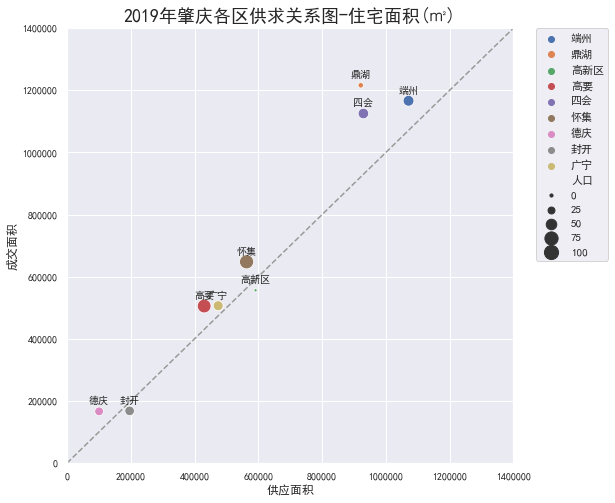

In [24]:
# 各区供应量、成交量散点图
def p6_area(indicator_):
    # indicator_ = 住宅面积/商业面积/办公面积/其他面积/商品房面积
    
    data = f6(indicator_)
    data.drop(['肇庆'],axis = 0,inplace = True)
    # 生成数据集
    
    sns.set(font='SimHei')
    #cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    markers = {'端州':'s','鼎湖':'o','高新区':'v','高要':'d','四会':'p','怀集':'X','德庆':'*','封开':'3','广宁':'4'}
    
    fig,ax = plt.subplots(figsize = (8,8))
    ax = sns.scatterplot(x = data.columns[0],y = data.columns[1],
                         hue = data.index,
                         size = '人口',
                         #markers = markers,
                         #style = data.index,   # 标记分类最多只能是8个
                         #palette=cmap,
                         sizes=(10,200),
                         data = data
                        )
    ax.plot([0, 1400000], [0, 1400000], ls = "--", c = ".6")   # 对角线
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0)   # 设置图例在图像外
    plt.xlim(0,1400000)
    plt.ylim(0,1400000)
    plt.xticks(size = 10)
    plt.yticks(size = 10)
    plt.title('2019年肇庆各区供求关系图-' + indicator_ + '(㎡)',fontsize= 18)
    for a,b,c in zip(data['供应面积'],data['成交面积'],data.index):
        plt.text(a,b+20000,'%s' % c,ha = 'center',va = 'bottom',fontsize = 10)
    
    #return data

p6_area('住宅面积')

In [35]:
pp = p6('住宅套数')
ppc = pp.columns[0]
ppc

'供应套数'